This notebook completes all of the same tasks as 2.0 but with one primary difference.

We re-balanced the dataset, such that one record from the train sets of both the single and multi tasks were stochastically tested so that the following constraints were maintained:

- 1) the values of each sub-set's quartiles remained within 1 standard deviation of each other (just as in the original dataset's close relationship between continuous quartile values)
- 2) the balance of the counts of binarized values remain similarly close together, as in the original dataset
- 3) the balance of counts of subcorpora remain similarly close, as in the original dataset

Originally the single task had:
- 7662 train records
- 421 validation records
- 917 test records

We re-balanced to have in the single set:
- 7000 train records
- 1000 validation records
- 1000 test records

For the multi set, we originally had:
- 1517 train records
- 99 validation records
- 184 test records

We re-balanced to have in the single set:
- 1300 train records
- 250 validation records
- 250 test records

This additional work was performed in order to rule out dataset imbalance issues (predominantly in the validation set) causing 100% recall and precision scores, and highly consistent test F1 scores, across multiple training runs on multiple distinct model architectures

In [ ]:
#@title Install Packages

In [ ]:
# !pip install -q transformers
# !pip install -q torchinfo
!pip install -q datasets
# !pip install -q evaluate
!pip install -q nltk
!pip install -q contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 5.5 MB/s eta 0:00:00


In [ ]:
!sudo apt-get update
! sudo apt-get install tree

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,099 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,542 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,833 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,788 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,690 k

In [ ]:
#@title Imports
import nltk
from nltk.tokenize import RegexpTokenizer

# import evaluate
# import transformers

import contractions

# from torchinfo import summary
# from datasets import load_dataset

# from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
# from transformers import TrainingArguments, Trainer

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

import sklearn

import spacy

In [ ]:
# @title Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_root = '/content/drive/MyDrive/266-final/'
# dir_data = '/content/drive/MyDrive/266-final/data/'
# dir_data = '/content/drive/MyDrive/266-final/data/se21-t1-comp-lex-master/'
dir_data = '/content/drive/MyDrive/266-final/data/266-comp-lex-master'
dir_models = '/content/drive/MyDrive/266-final/models/'
dir_results = '/content/drive/MyDrive/266-final/results/'

In [ ]:
!tree /content/drive/MyDrive/266-final/data/266-comp-lex-master/

/content/drive/MyDrive/266-final/data/266-comp-lex-master/
├── fe-test-labels
│   ├── test_multi_df.csv
│   └── test_single_df.csv
├── fe-train
│   ├── train_multi_df.csv
│   └── train_single_df.csv
├── fe-trial-val
│   ├── trial_val_multi_df.csv
│   └── trial_val_single_df.csv
├── test-labels
│   ├── lcp_multi_test.tsv
│   └── lcp_single_test.tsv
├── train
│   ├── lcp_multi_train.tsv
│   └── lcp_single_train.tsv
└── trial
    ├── lcp_multi_trial.tsv
    └── lcp_single_trial.tsv

6 directories, 12 files


In [ ]:
!ls -R /content/drive/MyDrive/266-final/data/266-comp-lex-master/

/content/drive/MyDrive/266-final/data/266-comp-lex-master/:
fe-test-labels	fe-train  fe-trial-val	test-labels  train  trial

/content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-test-labels:
test_multi_df.csv  test_single_df.csv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-train:
train_multi_df.csv  train_single_df.csv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-trial-val:
trial_val_multi_df.csv	trial_val_single_df.csv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/test-labels:
lcp_multi_test.tsv  lcp_single_test.tsv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/train:
lcp_multi_train.tsv  lcp_single_train.tsv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/trial:
lcp_multi_trial.tsv  lcp_single_trial.tsv


In [ ]:
#@title Import Data

In [ ]:
# Load train data into train_*_df
train_single_df = pd.read_csv(
    os.path.join(dir_data, "train", "lcp_single_train.tsv"),
    sep = "\t",
    engine = "python",
    quoting = 3
)
train_multi_df = pd.read_csv(
    os.path.join(dir_data, "train", "lcp_multi_train.tsv"),
    sep = "\t",
    engine = "python",
    quoting = 3
)

# Load trial data into trial_val_*_df
trial_val_single_df = pd.read_csv(
    os.path.join(dir_data, "trial", "lcp_single_trial.tsv"),
    sep = "\t",
    engine = "python",
    quoting = 3
)
trial_val_multi_df = pd.read_csv(
    os.path.join(dir_data, "trial", "lcp_multi_trial.tsv"),
    sep = "\t",
    engine = "python",
    quoting = 3
)

# Load test data (with labels) into test_*_df
test_single_df = pd.read_csv(
    os.path.join(dir_data, "test-labels", "lcp_single_test.tsv"),
    sep = "\t",
    engine = "python",
    quoting = 3
)
test_multi_df = pd.read_csv(
    os.path.join(dir_data, "test-labels", "lcp_multi_test.tsv"),
    sep = "\t",
    engine = "python",
    quoting = 3
)

print("Data successfully loaded into train, trial-val, and test variables")

Data successfully loaded into train, trial-val, and test variables


In [ ]:
#@title EDA

In [ ]:
def print_dataframe_summary(df_name, df):
    print(f"========== {df_name} ==========")

    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}\n")

    print("Data Types:")
    print(df.dtypes)
    print()

    print("Missing Values (by column):")
    print(df.isna().sum())
    print()

    desc = df['complexity'].describe()  # count, mean, std, min, 25%, 50%, 75%, max
    print("'complexity' Column Stats (incl. quartiles and median):")
    print(desc)

    q1 = desc['25%']
    q2 = desc['50%']  # This is the median
    q3 = desc['75%']
    q_max = desc['max']


    freq_q1 = np.sum(df['complexity'] <= q1)
    freq_q2 = np.sum((df['complexity'] > q1) & (df['complexity'] <= q2))
    freq_q3 = np.sum((df['complexity'] > q2) & (df['complexity'] <= q3))
    freq_q4 = np.sum(df['complexity'] > q3)

    print()
    print("Quartile Frequency Counts (tab-separated next to each quartile):")
    print(f"25%: {q1}\tCount (<= Q1): {freq_q1}")
    print(f"50% (Median): {q2}\tCount (Q1 < x <= Q2): {freq_q2}")
    print(f"75%: {q3}\tCount (Q2 < x <= Q3): {freq_q3}")
    print(f"100% (Max): {q_max}\tCount (Q3 < x <= Max): {freq_q4}")

    print("======================================\n")

print_dataframe_summary("train_single_df", train_single_df)
print_dataframe_summary("train_multi_df", train_multi_df)
print_dataframe_summary("trial_val_single_df", trial_val_single_df)
print_dataframe_summary("trial_val_multi_df", trial_val_multi_df)
print_dataframe_summary("test_single_df", test_single_df)
print_dataframe_summary("test_multi_df", test_multi_df)


========== train_single_df ==========
Shape: (7662, 5)
Columns: ['id', 'corpus', 'sentence', 'token', 'complexity']

Data Types:
id             object
corpus         object
sentence       object
token          object
complexity    float64
dtype: object

Missing Values (by column):
id            0
corpus        0
sentence      0
token         7
complexity    0
dtype: int64

'complexity' Column Stats (incl. quartiles and median):
count    7662.000000
mean        0.302288
std         0.132977
min         0.000000
25%         0.211538
50%         0.279412
75%         0.375000
max         0.861111
Name: complexity, dtype: float64

Quartile Frequency Counts (tab-separated next to each quartile):
25%: 0.2115384615384615	Count (<= Q1): 1928
50% (Median): 0.2794117647058823	Count (Q1 < x <= Q2): 1937
75%: 0.375	Count (Q2 < x <= Q3): 1984
100% (Max): 0.8611111111111112	Count (Q3 < x <= Max): 1813

========== train_multi_df ==========
Shape: (1517, 5)
Columns: ['id', 'corpus', 'sentence', 'token'

In [ ]:
print(train_single_df.head())

                               id corpus  \
0  3ZLW647WALVGE8EBR50EGUBPU4P32A  bible   
1  34R0BODSP1ZBN3DVY8J8XSIY551E5C  bible   
2  3S1WOPCJFGTJU2SGNAN2Y213N6WJE3  bible   
3  3BFNCI9LYKQN09BHXHH9CLSX5KP738  bible   
4  3G5RUKN2EC3YIWSKUXZ8ZVH95R49N2  bible   

                                            sentence     token  complexity  
0  Behold, there came up out of the river seven c...     river    0.000000  
1  I am a fellow bondservant with you and with yo...  brothers    0.000000  
2  The man, the lord of the land, said to us, 'By...  brothers    0.050000  
3  Shimei had sixteen sons and six daughters; but...  brothers    0.150000  
4               "He has put my brothers far from me.  brothers    0.263889  


In [ ]:
print(train_multi_df.head())

                               id corpus  \
0  3S37Y8CWI80N8KVM53U4E6JKCDC4WE  bible   
1  3WGCNLZJKF877FYC1Q6COKNWTDWD11  bible   
2  3UOMW19E6D6WQ5TH2HDD74IVKTP5CB  bible   
3  36JW4WBR06KF9AXMUL4N476OMF8FHD  bible   
4  3HRWUH63QU2FH9Q8R7MRNFC7JX2N5A  bible   

                                            sentence            token  \
0  but the seventh day is a Sabbath to Yahweh you...      seventh day   
1  But let each man test his own work, and then h...         own work   
2  To him who by understanding made the heavens; ...  loving kindness   
3  Remember to me, my God, this also, and spare m...  loving kindness   
4  Because your loving kindness is better than li...  loving kindness   

   complexity  
0    0.027778  
1    0.050000  
2    0.050000  
3    0.050000  
4    0.075000  


In [ ]:
#@title Data Engineering

In [ ]:

def print_distinct_values(df, column_name):
    """Prints the distinct values of a specified column in a DataFrame."""
    distinct_values = df[column_name].unique()
    print(f"Distinct values in '{column_name}' column:")
    for value in distinct_values:
        print(value)
    print("-" * 30)  # Separator

print_distinct_values(train_single_df, "corpus")
print_distinct_values(train_multi_df, "corpus")
print_distinct_values(trial_val_single_df, "subcorpus")
print_distinct_values(trial_val_multi_df, "subcorpus")
print_distinct_values(test_single_df, "corpus")
print_distinct_values(test_multi_df, "corpus")

Distinct values in 'corpus' column:
bible
biomed
europarl
------------------------------
Distinct values in 'corpus' column:
bible
biomed
europarl
------------------------------
Distinct values in 'subcorpus' column:
bible
biomed
europarl
------------------------------
Distinct values in 'subcorpus' column:
bible
biomed
europarl
------------------------------
Distinct values in 'corpus' column:
bible
biomed
europarl
------------------------------
Distinct values in 'corpus' column:
bible
biomed
europarl
------------------------------


## standardize column headers: convert trial_val header from 'subcorpus' to 'corpus'

In [ ]:
trial_val_single_df = trial_val_single_df.rename(columns={'subcorpus': 'corpus'})
trial_val_multi_df = trial_val_multi_df.rename(columns={'subcorpus': 'corpus'})

print(trial_val_single_df.columns)
print(trial_val_multi_df.columns)

Index(['id', 'corpus', 'sentence', 'token', 'complexity'], dtype='object')
Index(['id', 'corpus', 'sentence', 'token', 'complexity'], dtype='object')


In [ ]:
dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]

reference_headers = list(dataframes[0].columns)

all_headers_match = True
for df in dataframes[1:]:
    if list(df.columns) != reference_headers:
        all_headers_match = False
        print(f"Headers do not match for DataFrame: {df.head(0)}")  # Print which DataFrame has different headers
        break  # Exit the loop if a mismatch is found

if all_headers_match:
    print("All DataFrames have matching headers.")
else:
    print("Headers do not match for all DataFrames.")

All DataFrames have matching headers.


### Identify if any duplicates exist between sets

In [ ]:
single_dataframes = [train_single_df, trial_val_single_df, test_single_df]
multi_dataframes = [train_multi_df, trial_val_multi_df, test_multi_df]
single_names = ["train_single_df", "trial_val_single_df", "test_single_df"]
multi_names = ["train_multi_df", "trial_val_multi_df", "test_multi_df"]
for d in single_dataframes:
    d["is_duplicated"] = [{} for _ in range(len(d))]
for d in multi_dataframes:
    d["is_duplicated"] = [{} for _ in range(len(d))]
id_sets_single = {}
for n, d in zip(single_names, single_dataframes):
    id_sets_single[n] = set(d["id"].astype(str).dropna())
id_sets_multi = {}
for n, d in zip(multi_names, multi_dataframes):
    id_sets_multi[n] = set(d["id"].astype(str).dropna())
for df_name, df in zip(single_names, single_dataframes):
    print("Processing", df_name)
    for i in range(len(df)):
        row_id = str(df.loc[i, "id"])
        for other_name, other_df in zip(single_names, single_dataframes):
            if other_name != df_name:
                if row_id in id_sets_single[other_name]:
                    df.at[i, "is_duplicated"].setdefault(other_name, []).append(row_id)
    print("Done", df_name)
for df_name, df in zip(multi_names, multi_dataframes):
    print("Processing", df_name)
    for i in range(len(df)):
        row_id = str(df.loc[i, "id"])
        for other_name, other_df in zip(multi_names, multi_dataframes):
            if other_name != df_name:
                if row_id in id_sets_multi[other_name]:
                    df.at[i, "is_duplicated"].setdefault(other_name, []).append(row_id)
    print("Done", df_name)
duplicates_info_single = {}
for df_name, df in zip(single_names, single_dataframes):
    duplicates_info_single[df_name] = sum(len(x)>0 for x in df["is_duplicated"])
duplicates_info_multi = {}
for df_name, df in zip(multi_names, multi_dataframes):
    duplicates_info_multi[df_name] = sum(len(x)>0 for x in df["is_duplicated"])
print("Summary of single df duplicates:", duplicates_info_single)
print("Summary of multi df duplicates:", duplicates_info_multi)
frames_dup = []
for df in single_dataframes:
    frames_dup.append(df[df["is_duplicated"].apply(lambda x: len(x)>0)])
for df in multi_dataframes:
    frames_dup.append(df[df["is_duplicated"].apply(lambda x: len(x)>0)])
duplicate_qa_results_df = pd.concat(frames_dup, ignore_index=True)
print("Duplicates consolidated into duplicate_qa_results_df with shape:", duplicate_qa_results_df.shape)


Processing train_single_df
Done train_single_df
Processing trial_val_single_df
Done trial_val_single_df
Processing test_single_df
Done test_single_df
Processing train_multi_df
Done train_multi_df
Processing trial_val_multi_df
Done trial_val_multi_df
Processing test_multi_df
Done test_multi_df
Summary of single df duplicates: {'train_single_df': 0, 'trial_val_single_df': 0, 'test_single_df': 0}
Summary of multi df duplicates: {'train_multi_df': 0, 'trial_val_multi_df': 0, 'test_multi_df': 0}
Duplicates consolidated into duplicate_qa_results_df with shape: (0, 6)


- no duplictes exist

In [ ]:
1000-917

83

In [ ]:
1000-421

579

In [ ]:
83+579

662

In [ ]:
7662-7662

0

In [ ]:
dataframes = [
    ("train_single_df", train_single_df),
    ("train_multi_df", train_multi_df),
    ("trial_val_multi_df", trial_val_multi_df),
    ("test_single_df", test_single_df),
    ("test_multi_df", test_multi_df),
]

expected_corpora = ["bible", "europarl", "biomed"]

overall_sums = defaultdict(int)

for name, df in dataframes:
    counts = df["corpus"].value_counts()

    corpus_counts = counts.reindex(expected_corpora, fill_value=0)

    for c in expected_corpora:
        overall_sums[c] += corpus_counts[c]

    print(f"Counts for {name}:")
    print(corpus_counts)
    print("-" * 40)

print("Overall sums across all dataframes:")
for c in expected_corpora:
    print(f"{c}: {overall_sums[c]}")


Counts for train_single_df:
corpus
bible       2574
europarl    2512
biomed      2576
Name: count, dtype: int64
----------------------------------------
Counts for train_multi_df:
corpus
bible       505
europarl    498
biomed      514
Name: count, dtype: int64
----------------------------------------
Counts for trial_val_single_df:
corpus
bible       143
europarl    143
biomed      135
Name: count, dtype: int64
----------------------------------------
Counts for trial_val_multi_df:
corpus
bible       29
europarl    37
biomed      33
Name: count, dtype: int64
----------------------------------------
Counts for test_single_df:
corpus
bible       283
europarl    345
biomed      289
Name: count, dtype: int64
----------------------------------------
Counts for test_multi_df:
corpus
bible       66
europarl    65
biomed      53
Name: count, dtype: int64
----------------------------------------
Overall sums across all dataframes:
bible: 3600
europarl: 3600
biomed: 3600


In [ ]:
import numpy as np
import pandas as pd

print("Begin rebalancing multi dataset")
m_needed_test = 250 - len(test_multi_df)
m_needed_val = 250 - len(trial_val_multi_df)
print("Required additions to multi test:", m_needed_test)
print("Required additions to multi validation:", m_needed_val)
m_corpus_vals = train_multi_df["corpus"].unique()
m_q = np.quantile(train_multi_df["complexity"], [0.25, 0.5, 0.75])
print("Multi train quartiles:", m_q)
m_stddev_quart = np.std([
    np.sum((train_multi_df["complexity"] <= m_q[0])),
    np.sum((train_multi_df["complexity"] > m_q[0]) & (train_multi_df["complexity"] <= m_q[1])),
    np.sum((train_multi_df["complexity"] > m_q[1]) & (train_multi_df["complexity"] <= m_q[2])),
    np.sum(train_multi_df["complexity"] > m_q[2])
])
print("Multi train quartile count std dev:", m_stddev_quart)
m_test_split = {}
m_val_split = {}
for c in m_corpus_vals:
    m_count_test = int(np.floor(m_needed_test / len(m_corpus_vals)))
    m_count_val = int(np.floor(m_needed_val / len(m_corpus_vals)))
    if c == m_corpus_vals[-1]:
        m_count_test = m_needed_test - sum(m_test_split.values())
        m_count_val = m_needed_val - sum(m_val_split.values())
    m_subset_c = train_multi_df[train_multi_df["corpus"] == c]
    attempts_test = m_subset_c.sample(n=m_count_test, random_state=42, replace=False) if m_count_test > 0 else m_subset_c.iloc[0:0]
    attempts_val = m_subset_c.drop(attempts_test.index).sample(n=m_count_val, random_state=84, replace=False) if m_count_val > 0 else m_subset_c.iloc[0:0]
    m_test_split[c] = len(attempts_test)
    m_val_split[c] = len(attempts_val)
    train_multi_df.drop(attempts_test.index, inplace=True)
    train_multi_df.drop(attempts_val.index, inplace=True)
    test_multi_df = pd.concat([test_multi_df, attempts_test], ignore_index=True)
    trial_val_multi_df = pd.concat([trial_val_multi_df, attempts_val], ignore_index=True)
print("Multi corpus distribution moved to test:", m_test_split)
print("Multi corpus distribution moved to validation:", m_val_split)
print("Checking quartiles across multi dataframes after move")
m_train_counts_quart = [
    np.sum((train_multi_df["complexity"] <= m_q[0])),
    np.sum((train_multi_df["complexity"] > m_q[0]) & (train_multi_df["complexity"] <= m_q[1])),
    np.sum((train_multi_df["complexity"] > m_q[1]) & (train_multi_df["complexity"] <= m_q[2])),
    np.sum(train_multi_df["complexity"] > m_q[2])
]
m_val_counts_quart = [
    np.sum((trial_val_multi_df["complexity"] <= m_q[0])),
    np.sum((trial_val_multi_df["complexity"] > m_q[0]) & (trial_val_multi_df["complexity"] <= m_q[1])),
    np.sum((trial_val_multi_df["complexity"] > m_q[1]) & (trial_val_multi_df["complexity"] <= m_q[2])),
    np.sum(trial_val_multi_df["complexity"] > m_q[2])
]
m_test_counts_quart = [
    np.sum((test_multi_df["complexity"] <= m_q[0])),
    np.sum((test_multi_df["complexity"] > m_q[0]) & (test_multi_df["complexity"] <= m_q[1])),
    np.sum((test_multi_df["complexity"] > m_q[1]) & (test_multi_df["complexity"] <= m_q[2])),
    np.sum(test_multi_df["complexity"] > m_q[2])
]
print("Multi train quartile distribution:", m_train_counts_quart)
print("Multi validation quartile distribution:", m_val_counts_quart)
print("Multi test quartile distribution:", m_test_counts_quart)
print("Ensuring quartile counts remain within 1 std of original train distribution")
m_final_std_train = np.std(m_train_counts_quart)
m_final_std_val = np.std(m_val_counts_quart)
m_final_std_test = np.std(m_test_counts_quart)
print("Multi final train quartile count std dev:", m_final_std_train)
print("Multi final validation quartile count std dev:", m_final_std_val)
print("Multi final test quartile count std dev:", m_final_std_test)
print("Summing corpus counts across the six dataframes")
for c in m_corpus_vals:
    s1 = len(train_single_df[train_single_df["corpus"] == c])
    s2 = len(trial_val_single_df[trial_val_single_df["corpus"] == c])
    s3 = len(test_single_df[test_single_df["corpus"] == c])
    m1 = len(train_multi_df[train_multi_df["corpus"] == c])
    m2 = len(trial_val_multi_df[trial_val_multi_df["corpus"] == c])
    m3 = len(test_multi_df[test_multi_df["corpus"] == c])
    print("Corpus", c, "counts across six dataframes:", [s1, s2, s3, m1, m2, m3])
print("Shuffling multi dataframes")
train_multi_df = train_multi_df.sample(frac=1, random_state=101).reset_index(drop=True)
trial_val_multi_df = trial_val_multi_df.sample(frac=1, random_state=102).reset_index(drop=True)
test_multi_df = test_multi_df.sample(frac=1, random_state=103).reset_index(drop=True)
print("Finished rebalancing multi dataset")

print("Begin rebalancing single dataset")
s_needed_test = 1000 - len(test_single_df)
s_needed_val = 1000 - len(trial_val_single_df)
print("Required additions to single test:", s_needed_test)
print("Required additions to single validation:", s_needed_val)
s_corpus_vals = train_single_df["corpus"].unique()
s_q = np.quantile(train_single_df["complexity"], [0.25, 0.5, 0.75])
print("Single train quartiles:", s_q)
s_stddev_quart = np.std([
    np.sum((train_single_df["complexity"] <= s_q[0])),
    np.sum((train_single_df["complexity"] > s_q[0]) & (train_single_df["complexity"] <= s_q[1])),
    np.sum((train_single_df["complexity"] > s_q[1]) & (train_single_df["complexity"] <= s_q[2])),
    np.sum(train_single_df["complexity"] > s_q[2])
])
print("Single train quartile count std dev:", s_stddev_quart)
s_test_split = {}
s_val_split = {}
for c in s_corpus_vals:
    s_count_test = int(np.floor(s_needed_test / len(s_corpus_vals)))
    s_count_val = int(np.floor(s_needed_val / len(s_corpus_vals)))
    if c == s_corpus_vals[-1]:
        s_count_test = s_needed_test - sum(s_test_split.values())
        s_count_val = s_needed_val - sum(s_val_split.values())
    s_subset_c = train_single_df[train_single_df["corpus"] == c]
    s_attempts_test = s_subset_c.sample(n=s_count_test, random_state=44, replace=False) if s_count_test > 0 else s_subset_c.iloc[0:0]
    s_attempts_val = s_subset_c.drop(s_attempts_test.index).sample(n=s_count_val, random_state=55, replace=False) if s_count_val > 0 else s_subset_c.iloc[0:0]
    s_test_split[c] = len(s_attempts_test)
    s_val_split[c] = len(s_attempts_val)
    train_single_df.drop(s_attempts_test.index, inplace=True)
    train_single_df.drop(s_attempts_val.index, inplace=True)
    test_single_df = pd.concat([test_single_df, s_attempts_test], ignore_index=True)
    trial_val_single_df = pd.concat([trial_val_single_df, s_attempts_val], ignore_index=True)
print("Single corpus distribution moved to test:", s_test_split)
print("Single corpus distribution moved to validation:", s_val_split)
print("Checking quartiles across single dataframes after move")
s_train_counts_quart = [
    np.sum((train_single_df["complexity"] <= s_q[0])),
    np.sum((train_single_df["complexity"] > s_q[0]) & (train_single_df["complexity"] <= s_q[1])),
    np.sum((train_single_df["complexity"] > s_q[1]) & (train_single_df["complexity"] <= s_q[2])),
    np.sum(train_single_df["complexity"] > s_q[2])
]
s_val_counts_quart = [
    np.sum((trial_val_single_df["complexity"] <= s_q[0])),
    np.sum((trial_val_single_df["complexity"] > s_q[0]) & (trial_val_single_df["complexity"] <= s_q[1])),
    np.sum((trial_val_single_df["complexity"] > s_q[1]) & (trial_val_single_df["complexity"] <= s_q[2])),
    np.sum(trial_val_single_df["complexity"] > s_q[2])
]
s_test_counts_quart = [
    np.sum((test_single_df["complexity"] <= s_q[0])),
    np.sum((test_single_df["complexity"] > s_q[0]) & (test_single_df["complexity"] <= s_q[1])),
    np.sum((test_single_df["complexity"] > s_q[1]) & (test_single_df["complexity"] <= s_q[2])),
    np.sum(test_single_df["complexity"] > s_q[2])
]
print("Single train quartile distribution:", s_train_counts_quart)
print("Single validation quartile distribution:", s_val_counts_quart)
print("Single test quartile distribution:", s_test_counts_quart)
print("Ensuring quartile counts remain within 1 std of original train distribution")
s_final_std_train = np.std(s_train_counts_quart)
s_final_std_val = np.std(s_val_counts_quart)
s_final_std_test = np.std(s_test_counts_quart)
print("Single final train quartile count std dev:", s_final_std_train)
print("Single final validation quartile count std dev:", s_final_std_val)
print("Single final test quartile count std dev:", s_final_std_test)
print("Summing corpus counts across the six dataframes")
for c in s_corpus_vals:
    s1 = len(train_single_df[train_single_df["corpus"] == c])
    s2 = len(trial_val_single_df[trial_val_single_df["corpus"] == c])
    s3 = len(test_single_df[test_single_df["corpus"] == c])
    m1 = len(train_multi_df[train_multi_df["corpus"] == c])
    m2 = len(trial_val_multi_df[trial_val_multi_df["corpus"] == c])
    m3 = len(test_multi_df[test_multi_df["corpus"] == c])
    print("Corpus", c, "counts across six dataframes:", [s1, s2, s3, m1, m2, m3])
print("Shuffling single dataframes")
train_single_df = train_single_df.sample(frac=1, random_state=201).reset_index(drop=True)
trial_val_single_df = trial_val_single_df.sample(frac=1, random_state=202).reset_index(drop=True)
test_single_df = test_single_df.sample(frac=1, random_state=203).reset_index(drop=True)
print("Finished rebalancing single dataset")


Begin rebalancing multi dataset
Required additions to multi test: 66
Required additions to multi validation: 151
Multi train quartiles: [0.30263158 0.40909091 0.52941176]
Multi train quartile count std dev: 1.920286436967152
Multi corpus distribution moved to test: {'bible': 22, 'biomed': 22, 'europarl': 22}
Multi corpus distribution moved to validation: {'bible': 50, 'biomed': 50, 'europarl': 51}
Checking quartiles across multi dataframes after move
Multi train quartile distribution: [np.int64(324), np.int64(312), np.int64(340), np.int64(324)]
Multi validation quartile distribution: [np.int64(67), np.int64(71), np.int64(56), np.int64(56)]
Multi test quartile distribution: [np.int64(56), np.int64(62), np.int64(67), np.int64(65)]
Ensuring quartile counts remain within 1 std of original train distribution
Multi final train quartile count std dev: 9.9498743710662
Multi final validation quartile count std dev: 6.652067347825035
Multi final test quartile count std dev: 4.153311931459037
Sum

In [ ]:
dataframes = [
    ("train_single_df", train_single_df),
    ("train_multi_df", train_multi_df),
    ("trial_val_multi_df", trial_val_multi_df),
    ("test_single_df", test_single_df),
    ("test_multi_df", test_multi_df),
]

expected_corpora = ["bible", "europarl", "biomed"]

overall_sums = defaultdict(int)

for name, df in dataframes:
    counts = df["corpus"].value_counts()

    corpus_counts = counts.reindex(expected_corpora, fill_value=0)

    for c in expected_corpora:
        overall_sums[c] += corpus_counts[c]

    print(f"Counts for {name}:")
    print(corpus_counts)
    print("-" * 40)

print("Overall sums across all dataframes:")
for c in expected_corpora:
    print(f"{c}: {overall_sums[c]}")


Counts for train_single_df:
corpus
bible       2354
europarl    2290
biomed      2356
Name: count, dtype: int64
----------------------------------------
Counts for train_multi_df:
corpus
bible       433
europarl    425
biomed      442
Name: count, dtype: int64
----------------------------------------
Counts for trial_val_multi_df:
corpus
bible       79
europarl    88
biomed      83
Name: count, dtype: int64
----------------------------------------
Counts for test_single_df:
corpus
bible       310
europarl    374
biomed      316
Name: count, dtype: int64
----------------------------------------
Counts for test_multi_df:
corpus
bible       88
europarl    87
biomed      75
Name: count, dtype: int64
----------------------------------------
Overall sums across all dataframes:
bible: 3264
europarl: 3264
biomed: 3272


## Interrogate Span Length by Corpus Value by Data Split

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

def analyze_sentence_spans_by_corpus_and_quartile(dfs_dict):
    """
    Analyze sentence spans (length metrics) grouped by corpus and complexity quartile
    for multiple dataframes.
    """
    results = []

    for df_name, df in dfs_dict.items():
        print(f"Processing {df_name}...")

        q1 = df['complexity'].quantile(0.25)
        q2 = df['complexity'].quantile(0.50)
        q3 = df['complexity'].quantile(0.75)

        def get_quartile(x):
            if x <= q1:
                return 'Q1'
            elif x <= q2:
                return 'Q2'
            elif x <= q3:
                return 'Q3'
            else:
                return 'Q4'

        df = df.copy()
        df['quartile'] = df['complexity'].apply(get_quartile)

        def compute_span_metrics(sentence):
            if pd.isna(sentence):
                return pd.Series({'word_count': 0, 'char_count': 0, 'avg_word_len': 0})

            words = tokenizer.tokenize(sentence)
            word_count = len(words)
            char_count = len(sentence)
            avg_word_len = np.mean([len(word) for word in words]) if word_count > 0 else 0
            return pd.Series({'word_count': word_count, 'char_count': char_count, 'avg_word_len': avg_word_len})

        span_metrics = df['sentence'].apply(compute_span_metrics)
        df = pd.concat([df, span_metrics], axis=1)

        corpus_col = 'corpus' if 'corpus' in df.columns else 'subcorpus'

        for corpus_name, corpus_df in df.groupby(corpus_col):
            for quartile, quartile_df in corpus_df.groupby('quartile'):
                complexity_range = f"{quartile_df['complexity'].min():.3f}-{quartile_df['complexity'].max():.3f}"
                stats = {
                    'Dataframe': df_name,
                    'Corpus': corpus_name,
                    'Quartile': quartile,
                    'Complexity Range': complexity_range,
                    'Count': len(quartile_df),
                    'Avg Words': quartile_df['word_count'].mean(),
                    'Median Words': quartile_df['word_count'].median(),
                    'Min Words': quartile_df['word_count'].min(),
                    'Max Words': quartile_df['word_count'].max(),
                    'Std Words': quartile_df['word_count'].std(),
                    'Avg Chars': quartile_df['char_count'].mean(),
                    'Avg Word Len': quartile_df['avg_word_len'].mean()
                }
                results.append(stats)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(['Dataframe', 'Corpus', 'Quartile'])

    return results_df

dfs = {
    'train_single_df': train_single_df,
    'train_multi_df': train_multi_df,
    'trial_val_single_df': trial_val_single_df,
    'trial_val_multi_df': trial_val_multi_df,
    'test_single_df': test_single_df,
    'test_multi_df': test_multi_df
}

span_analysis = analyze_sentence_spans_by_corpus_and_quartile(dfs)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
display(span_analysis)

results_path = os.path.join(dir_results, 'sentence_span_analysis.csv')
span_analysis.to_csv(results_path, index=False)
print(f"Analysis saved to: {results_path}")

Processing train_single_df...
Processing train_multi_df...
Processing trial_val_single_df...
Processing trial_val_multi_df...
Processing test_single_df...
Processing test_multi_df...


,Dataframe,Corpus,Quartile,Complexity Range,Count,Avg Words,Median Words,Min Words,Max Words,Std Words,Avg Chars,Avg Word Len
60,test_multi_df,bible,Q1,0.025-0.317,33,24.333333,23.0,4.0,48.0,12.516656,125.181818,4.123212
61,test_multi_df,bible,Q2,0.325-0.417,18,18.611111,16.0,6.0,47.0,10.987366,99.666667,4.216215
62,test_multi_df,bible,Q3,0.432-0.528,20,20.350000,21.0,4.0,43.0,10.624079,108.500000,4.423550
63,test_multi_df,bible,Q4,0.533-0.694,17,21.411765,20.0,3.0,51.0,12.384763,117.647059,4.556087
64,test_multi_df,biomed,Q1,0.000-0.312,15,26.200000,27.0,10.0,47.0,10.093845,171.000000,5.372335
65,test_multi_df,biomed,Q2,0.324-0.417,13,27.384615,24.0,9.0,47.0,10.484421,174.615385,5.445863
66,test_multi_df,biomed,Q3,0.434-0.528,14,29.714286,26.5,10.0,61.0,13.498881,199.500000,5.624938
67,test_multi_df,biomed,Q4,0.544-0.806,33,31.696970,28.0,14.0,56.0,12.746286,205.181818,5.421726
68,test_multi_df,europarl,Q1,0.172-0.317,17,27.647059,25.0,7.0,59.0,16.066040,165.588235,4.939143
69,test_multi_df,europarl,Q2,0.321-0.422,29,28.103448,28.0,9.0,73.0,14.326162,173.724138,5.279279


Analysis saved to: /content/drive/MyDrive/266-final/results/sentence_span_analysis.csv


<ipython-input-44-00a8ad5642c1>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(span_analysis, x='Avg Words', y='Dataframe', inner='stick', palette='Dark2')


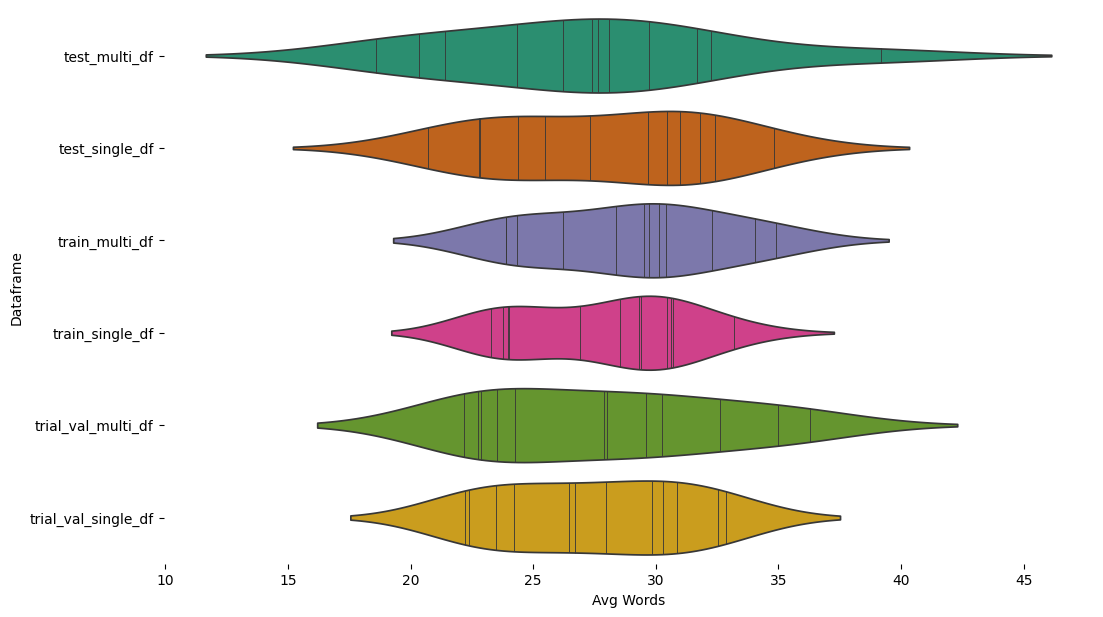

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(span_analysis['Dataframe'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(span_analysis, x='Avg Words', y='Dataframe', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

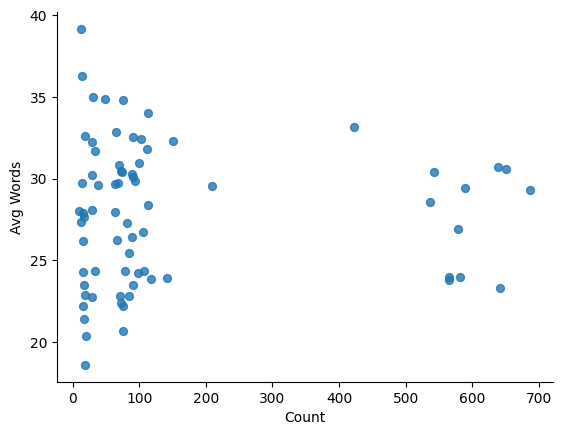

In [ ]:
from matplotlib import pyplot as plt
span_analysis.plot(kind='scatter', x='Count', y='Avg Words', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-46-01bf0c89d620>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(span_analysis, x='Max Words', y='Dataframe', inner='stick', palette='Dark2')


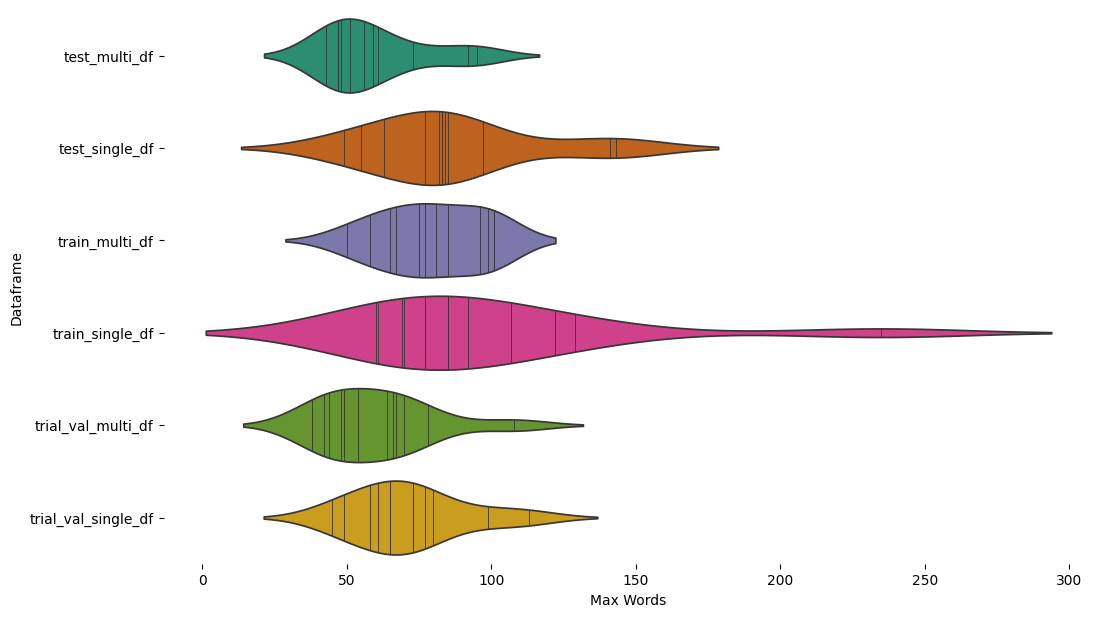

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(span_analysis['Dataframe'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(span_analysis, x='Max Words', y='Dataframe', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the sa

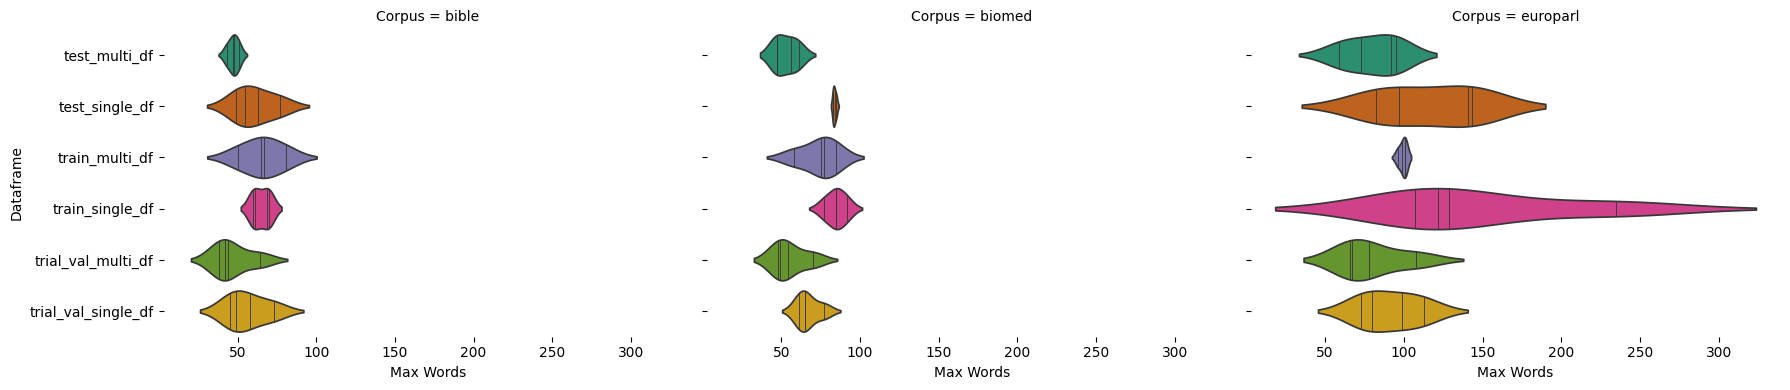

In [ ]:
g = sns.FacetGrid(span_analysis, col="Corpus", col_wrap=3, height=4, aspect=1.5)
g.map(sns.violinplot, "Max Words", "Dataframe", inner='stick', palette='Dark2')
g.despine(top=True, right=True, bottom=True, left=True)
plt.tight_layout()
plt.show()

- decision: no modifications to sentence spans will be applied, except for Contraction standardization

## Normalize / Eliminate Contractions

In [ ]:
def expand_contractions_in_df(df):
    """
    1) Creates a new column 'sentence_no_contractions' by expanding any contractions.
    2) Identifies rows where a contraction was actually expanded (the text changed).
    3) Returns the updated DataFrame and a grouped subset of rows for printing examples.
    """
    df = df.copy()
    df['sentence_no_contractions'] = df['sentence'].apply(
        lambda s: contractions.fix(s) if pd.notna(s) else s
    )

    df['contraction_expanded'] = df.apply(
        lambda row: row['sentence'] != row['sentence_no_contractions'], axis=1
    )

    results_by_corpus = {}
    for corpus_val, group in df.groupby('corpus'):
        changed_rows = group[group['contraction_expanded']]
        first_three = changed_rows.head(3)
        results_by_corpus[corpus_val] = first_three
    return df, results_by_corpus


dataframes_info = [
    ("train_single_df", train_single_df),
    ("train_multi_df", train_multi_df),
    ("trial_val_single_df", trial_val_single_df),
    ("trial_val_multi_df", trial_val_multi_df),
    ("test_single_df", test_single_df),
    ("test_multi_df", test_multi_df),
]

for df_name, df in dataframes_info:
    updated_df, corpus_examples = expand_contractions_in_df(df)
    globals()[df_name] = updated_df

    print(f"\n{'='*60}")
    print(f"DataFrame: {df_name}")
    print(f"{'='*60}")

    for corpus_val in sorted(corpus_examples.keys()):
        subset = corpus_examples[corpus_val]
        if len(subset) == 0:
            continue
        print(f"\n  Corpus: {corpus_val}")
        print("    -- BEFORE --")
        for _, row in subset.iterrows():
            print(f"       {row['sentence']}")
        print("    -- AFTER  --")
        for _, row in subset.iterrows():
            print(f"       {row['sentence_no_contractions']}")


DataFrame: train_single_df

  Corpus: bible
    -- BEFORE --
       He who is a hired hand, and not a shepherd, who doesn't own the sheep, sees the wolf coming, leaves the sheep, and flees.
       Bring forth therefore fruits worthy of repentance, and don't begin to say among yourselves, 'We have Abraham for our father;' for I tell you that God is able to raise up children to Abraham from these stones!
       But Jonathan didn't hear when his father commanded the people with the oath: therefore he put forth the end of the rod who was in his hand, and dipped it in the honeycomb, and put his hand to his mouth; and his eyes were enlightened.
    -- AFTER  --
       He who is a hired hand, and not a shepherd, who does not own the sheep, sees the wolf coming, leaves the sheep, and flees.
       Bring forth therefore fruits worthy of repentance, and do not begin to say among yourselves, 'We have Abraham for our father;' for I tell you that God is able to raise up children to Abraham from th

In [ ]:
# check for null values

dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]
for df in dataframes:
  print(df['sentence_no_contractions'].isnull().values.any())

False
False
False
False
False
False


In [ ]:
dataframes = {
    "train_single_df": train_single_df,
    "train_multi_df": train_multi_df,
    "trial_val_single_df": trial_val_single_df,
    "trial_val_multi_df": trial_val_multi_df,
    "test_single_df": test_single_df,
    "test_multi_df": test_multi_df
}

total_true_counts = 0
for df_name, df in dataframes.items():
    true_count = df['contraction_expanded'].sum()
    print(f"{df_name}: {true_count} True values in 'contraction_expanded'")
    total_true_counts += true_count

print(f"\nTotal True values across all dataframes: {total_true_counts}")

train_single_df: 230 True values in 'contraction_expanded'
train_multi_df: 44 True values in 'contraction_expanded'
trial_val_single_df: 38 True values in 'contraction_expanded'
trial_val_multi_df: 8 True values in 'contraction_expanded'
test_single_df: 33 True values in 'contraction_expanded'
test_multi_df: 9 True values in 'contraction_expanded'

Total True values across all dataframes: 362


In [ ]:
# verify column headers

dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]
for df in dataframes:
  print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        7000 non-null   object 
 1   corpus                    7000 non-null   object 
 2   sentence                  7000 non-null   object 
 3   token                     6995 non-null   object 
 4   complexity                7000 non-null   float64
 5   is_duplicated             7000 non-null   object 
 6   sentence_no_contractions  7000 non-null   object 
 7   contraction_expanded      7000 non-null   bool   
dtypes: bool(1), float64(1), object(6)
memory usage: 389.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1300 non-null   object 
 1   

In [ ]:
# inspect each df

dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]
for df in dataframes:
  print(df.head())

                               id    corpus                                           sentence            token  complexity is_duplicated                           sentence_no_contractions  contraction_expanded
0  3IQ9O0AYW6ZPOAQ7VNRXLNM4D1DITZ    biomed  The development of sexually dimorphic reproduc...           organs    0.250000            {}  The development of sexually dimorphic reproduc...                 False
1  3PA41K45VN4U7YG4VFEGPOVYAII7PP    biomed  We find that the majority of the olfactory rec...            usage    0.382353            {}  We find that the majority of the olfactory rec...                 False
2  36818Z1KV3D5JB9F4KTTMCUN6U7A3I     bible  His lord was angry, and delivered him to the t...       tormentors    0.328947            {}  His lord was angry, and delivered him to the t...                 False
3  3VJ4PFXFJ37PI5MYJ4PU9LKNJ9SUAF  europarl  The Taiwanese Government has informed the Coun...  representations    0.315789            {}  The Taiwanese Gov

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

def analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs_dict):
    """
    Analyze sentence spans (length metrics) grouped by corpus and complexity quartile
    for multiple dataframes, but this time using the 'sentence_no_contractions' column
    instead of the original 'sentence'.
    """
    results = []

    for df_name, df in dfs_dict.items():
        print(f"Processing {df_name} on 'sentence_no_contractions'...")
        df = df.copy()

        q1 = df['complexity'].quantile(0.25)
        q2 = df['complexity'].quantile(0.50)
        q3 = df['complexity'].quantile(0.75)

        def get_quartile(x):
            if x <= q1:
                return 'Q1'
            elif x <= q2:
                return 'Q2'
            elif x <= q3:
                return 'Q3'
            else:
                return 'Q4'

        df['quartile'] = df['complexity'].apply(get_quartile)

        def compute_span_metrics_no_contracts(sentence):
            if pd.isna(sentence):
                return pd.Series({'word_count': 0, 'char_count': 0, 'avg_word_len': 0})

            words = tokenizer.tokenize(sentence)
            word_count = len(words)
            char_count = len(sentence)
            avg_word_len = np.mean([len(w) for w in words]) if word_count > 0 else 0

            return pd.Series({
                'word_count': word_count,
                'char_count': char_count,
                'avg_word_len': avg_word_len
            })

        span_metrics_nc = df['sentence_no_contractions'].apply(compute_span_metrics_no_contracts)
        df = pd.concat([df, span_metrics_nc], axis=1)

        corpus_col = 'corpus'
        for corpus_name, corpus_df in df.groupby(corpus_col):
            for quartile, quartile_df in corpus_df.groupby('quartile'):
                complexity_range = f"{quartile_df['complexity'].min():.3f}-{quartile_df['complexity'].max():.3f}"
                stats = {
                    'Dataframe': df_name,
                    'Corpus': corpus_name,
                    'Quartile': quartile,
                    'Complexity Range': complexity_range,
                    'Count': len(quartile_df),
                    'Avg Words': quartile_df['word_count'].mean(),
                    'Median Words': quartile_df['word_count'].median(),
                    'Min Words': quartile_df['word_count'].min(),
                    'Max Words': quartile_df['word_count'].max(),
                    'Std Words': quartile_df['word_count'].std(),
                    'Avg Chars': quartile_df['char_count'].mean(),
                    'Avg Word Len': quartile_df['avg_word_len'].mean()
                }
                results.append(stats)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(['Dataframe', 'Corpus', 'Quartile'])
    return results_df


dfs = {
    'train_single_df': train_single_df,
    'train_multi_df': train_multi_df,
    'trial_val_single_df': trial_val_single_df,
    'trial_val_multi_df': trial_val_multi_df,
    'test_single_df': test_single_df,
    'test_multi_df': test_multi_df
}

span_analysis_nc = analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
display(span_analysis_nc)


Processing train_single_df on 'sentence_no_contractions'...
Processing train_multi_df on 'sentence_no_contractions'...
Processing trial_val_single_df on 'sentence_no_contractions'...
Processing trial_val_multi_df on 'sentence_no_contractions'...
Processing test_single_df on 'sentence_no_contractions'...
Processing test_multi_df on 'sentence_no_contractions'...


,Dataframe,Corpus,Quartile,Complexity Range,Count,Avg Words,Median Words,Min Words,Max Words,Std Words,Avg Chars,Avg Word Len
60,test_multi_df,bible,Q1,0.025-0.317,33,24.333333,23.0,4.0,48.0,12.516656,125.272727,4.126658
61,test_multi_df,bible,Q2,0.325-0.417,18,18.611111,16.0,6.0,47.0,10.987366,99.722222,4.218529
62,test_multi_df,bible,Q3,0.432-0.528,20,20.300000,21.0,4.0,43.0,10.578528,108.850000,4.445514
63,test_multi_df,bible,Q4,0.533-0.694,17,21.411765,20.0,3.0,51.0,12.384763,117.647059,4.556087
64,test_multi_df,biomed,Q1,0.000-0.312,15,26.200000,27.0,10.0,47.0,10.093845,171.000000,5.372335
65,test_multi_df,biomed,Q2,0.324-0.417,13,27.384615,24.0,9.0,47.0,10.484421,174.615385,5.445863
66,test_multi_df,biomed,Q3,0.434-0.528,14,29.714286,26.5,10.0,61.0,13.498881,199.500000,5.624938
67,test_multi_df,biomed,Q4,0.544-0.806,33,31.696970,28.0,14.0,56.0,12.746286,205.181818,5.421726
68,test_multi_df,europarl,Q1,0.172-0.317,17,27.647059,25.0,7.0,59.0,16.066040,165.705882,4.942084
69,test_multi_df,europarl,Q2,0.321-0.422,29,28.103448,28.0,9.0,73.0,14.326162,173.724138,5.279279


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the sa

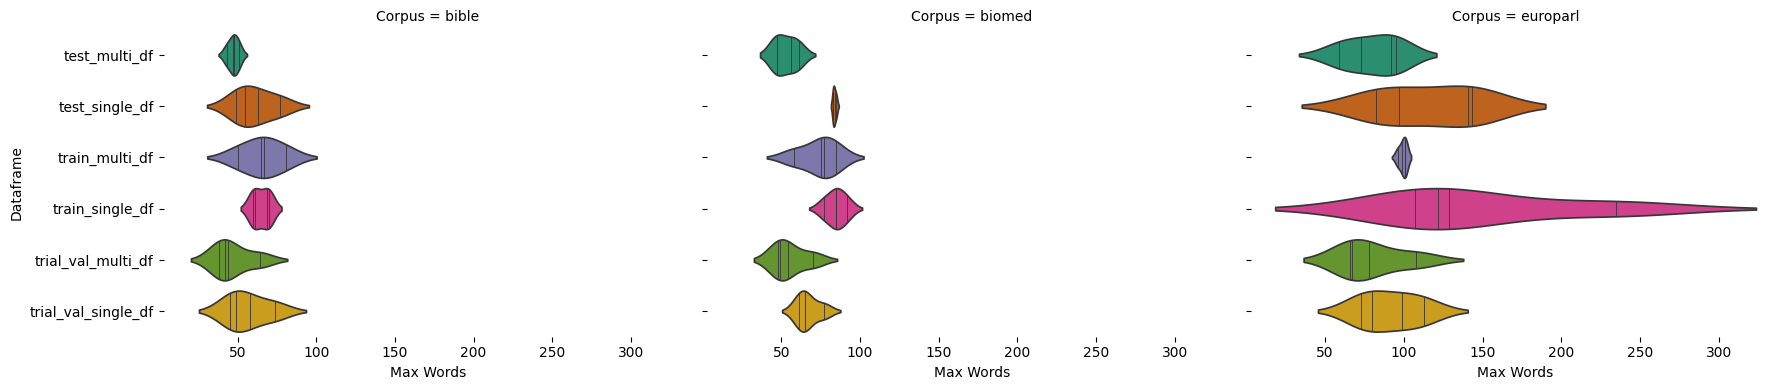

In [ ]:
g = sns.FacetGrid(span_analysis_nc, col="Corpus", col_wrap=3, height=4, aspect=1.5)
g.map(sns.violinplot, "Max Words", "Dataframe", inner='stick', palette='Dark2')
g.despine(top=True, right=True, bottom=True, left=True)
plt.tight_layout()
plt.show()

- contraction processing successfuly, confirmed with Avg Word deltas between 'sentence' and 'sentence_no_contractions'

## Enrich Datset with PoS Tags, Dependency Parsing, and Morphological Complexity

In [ ]:
# !pip install -q spacy
# !python -m spacy download en_core_web_trf
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 2.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
nlp = spacy.load("en_core_web_lg")


In [ ]:
text = "This is a sample sentence for testing spaCy."

doc = nlp(text)

for token in doc:
    print(f"Token: {token.text}, POS: {token.pos_}, Dependency: {token.dep_}")


Token: This, POS: PRON, Dependency: nsubj
Token: is, POS: AUX, Dependency: ROOT
Token: a, POS: DET, Dependency: det
Token: sample, POS: NOUN, Dependency: compound
Token: sentence, POS: NOUN, Dependency: attr
Token: for, POS: ADP, Dependency: prep
Token: testing, POS: VERB, Dependency: pcomp
Token: spaCy, POS: PROPN, Dependency: dobj
Token: ., POS: PUNCT, Dependency: punct


In [ ]:
def enrich_with_spacy(df, text_col='sentence_no_contractions'):
    """
    Processes the 'text_col' with spaCy and appends:
      pos_sequence, dep_sequence, morph_sequence,
      and morph_complexity (float) per row.
    """
    df = df.copy()

    pos_tags = []
    dep_tags = []
    morph_tags = []
    morph_complexities = []

    for text in df[text_col]:
        if pd.isna(text) or not text.strip():
            pos_tags.append([])
            dep_tags.append([])
            morph_tags.append([])
            morph_complexities.append(0.0)
            continue

        doc = nlp(text)

        pos_seq = [token.pos_ for token in doc]
        dep_seq = [token.dep_ for token in doc]
        morph_seq = [token.morph for token in doc]

        total_features = 0
        for token in doc:
            features_dict = token.morph.to_dict()
            total_features += len(features_dict)

        avg_morph = total_features / len(doc)

        pos_tags.append(pos_seq)
        dep_tags.append(dep_seq)
        morph_tags.append(morph_seq)
        morph_complexities.append(avg_morph)

    df['pos_sequence'] = pos_tags
    df['dep_sequence'] = dep_tags
    df['morph_sequence'] = morph_tags
    df['morph_complexity'] = morph_complexities

    return df


In [ ]:
dataframes_info = [
    ("train_single_df", train_single_df),
    ("train_multi_df", train_multi_df),
    ("trial_val_single_df", trial_val_single_df),
    ("trial_val_multi_df", trial_val_multi_df),
    ("test_single_df", test_single_df),
    ("test_multi_df", test_multi_df),
]

for df_name, df in dataframes_info:
    print(f"Enriching {df_name} with spaCy features...")
    enriched_df = enrich_with_spacy(df, text_col='sentence_no_contractions')
    globals()[df_name] = enriched_df
    print(f"Done! Now '{df_name}' has columns: pos_sequence, dep_sequence, morph_sequence, morph_complexity.\n")


Enriching train_single_df with spaCy features...
Done! Now 'train_single_df' has columns: pos_sequence, dep_sequence, morph_sequence, morph_complexity.

Enriching train_multi_df with spaCy features...
Done! Now 'train_multi_df' has columns: pos_sequence, dep_sequence, morph_sequence, morph_complexity.

Enriching trial_val_single_df with spaCy features...
Done! Now 'trial_val_single_df' has columns: pos_sequence, dep_sequence, morph_sequence, morph_complexity.

Enriching trial_val_multi_df with spaCy features...
Done! Now 'trial_val_multi_df' has columns: pos_sequence, dep_sequence, morph_sequence, morph_complexity.

Enriching test_single_df with spaCy features...
Done! Now 'test_single_df' has columns: pos_sequence, dep_sequence, morph_sequence, morph_complexity.

Enriching test_multi_df with spaCy features...
Done! Now 'test_multi_df' has columns: pos_sequence, dep_sequence, morph_sequence, morph_complexity.



In [ ]:
for df_name, df in dataframes_info:
    print(f"\n{'='*50}")
    print(f"DataFrame: {df_name}")
    print(f"{'='*50}\n")
    sample_df = globals()[df_name].sample(3, random_state=42)
    display(sample_df[['sentence_no_contractions', 'pos_sequence', 'dep_sequence', 'morph_sequence', 'morph_complexity']])



DataFrame: train_single_df



,sentence_no_contractions,pos_sequence,dep_sequence,morph_sequence,morph_complexity
6500,Our results and the sequences we provide will ...,"[PRON, NOUN, CCONJ, DET, NOUN, PRON, VERB, AUX...","[poss, nsubj, cc, det, conj, nsubj, relcl, aux...","[(Number=Plur, Person=1, Poss=Yes, PronType=Pr...",1.304348
2944,"had prepared for him a great room, where befor...","[AUX, VERB, ADP, PRON, DET, ADJ, NOUN, PUNCT, ...","[aux, ROOT, dative, pobj, det, amod, dobj, pun...","[(Tense=Past, VerbForm=Fin), (Aspect=Perf, Ten...",1.301587
2024,(EL) The next item is the statements by the Co...,"[PUNCT, PROPN, PUNCT, DET, ADJ, NOUN, AUX, DET...","[punct, ROOT, punct, det, amod, nsubj, ROOT, d...","[(PunctSide=Ini, PunctType=Brck), (Number=Sing...",1.421053



DataFrame: train_multi_df



,sentence_no_contractions,pos_sequence,dep_sequence,morph_sequence,morph_complexity
478,At the time I could not get a majority of Parl...,"[ADP, DET, NOUN, PRON, AUX, PART, VERB, DET, N...","[prep, det, pobj, nsubj, aux, neg, ccomp, det,...","[(), (Definite=Def, PronType=Art), (Number=Sin...",1.363636
721,'Mr Poos is known for both his opposition to T...,"[PUNCT, PROPN, PROPN, AUX, VERB, ADP, CCONJ, P...","[punct, compound, nsubjpass, auxpass, ROOT, pr...","[(PunctSide=Ini, PunctType=Quot), (Number=Sing...",1.521739
312,All of these findings raise many questions as ...,"[PRON, ADP, DET, NOUN, VERB, ADJ, NOUN, ADP, A...","[nsubj, prep, det, pobj, ROOT, amod, dobj, pre...","[(), (), (Number=Plur, PronType=Dem), (Number=...",0.892857



DataFrame: trial_val_single_df



,sentence_no_contractions,pos_sequence,dep_sequence,morph_sequence,morph_complexity
521,The aim of the meeting will be to formalise th...,"[DET, NOUN, ADP, DET, NOUN, AUX, AUX, PART, VE...","[det, nsubj, prep, det, pobj, aux, ROOT, aux, ...","[(Definite=Def, PronType=Art), (Number=Sing), ...",1.028571
737,SEM confirmed many of the observations made by...,"[PROPN, VERB, ADJ, ADP, DET, NOUN, VERB, ADP, ...","[nsubj, ROOT, dobj, prep, det, pobj, acl, agen...","[(Number=Sing), (Tense=Past, VerbForm=Fin), (D...",1.181818
740,It is a pleasure to welcome the Presidents and...,"[PRON, AUX, DET, NOUN, PART, VERB, DET, NOUN, ...","[nsubj, ROOT, det, attr, aux, relcl, det, dobj...","[(Case=Nom, Gender=Neut, Number=Sing, Person=3...",1.121212



DataFrame: trial_val_multi_df



,sentence_no_contractions,pos_sequence,dep_sequence,morph_sequence,morph_complexity
142,"The burden of Egypt: ""Behold, Yahweh rides on ...","[DET, NOUN, ADP, PROPN, PUNCT, PUNCT, VERB, PU...","[det, nsubj, prep, pobj, punct, punct, advcl, ...","[(Definite=Def, PronType=Art), (Number=Sing), ...",1.250000
6,They also allow for easy compensation for the ...,"[PRON, ADV, VERB, ADP, ADJ, NOUN, ADP, DET, NO...","[nsubj, advmod, ROOT, prep, amod, pobj, prep, ...","[(Case=Nom, Number=Plur, Person=3, PronType=Pr...",1.050000
97,This only records part of what I said.,"[PRON, ADV, VERB, NOUN, ADP, PRON, PRON, VERB,...","[nsubj, advmod, ROOT, dobj, prep, dobj, nsubj,...","[(Number=Sing, PronType=Dem), (), (Number=Sing...",1.555556



DataFrame: test_single_df



,sentence_no_contractions,pos_sequence,dep_sequence,morph_sequence,morph_complexity
521,On the ninth day of the fourth month the famin...,"[ADP, DET, ADJ, NOUN, ADP, DET, ADJ, NOUN, DET...","[prep, det, amod, pobj, prep, det, amod, pobj,...","[(), (Definite=Def, PronType=Art), (Degree=Pos...",1.172414
737,"Unfortunately, efforts to characterize cogniti...","[ADV, PUNCT, NOUN, PART, VERB, ADJ, NOUN, AUX,...","[advmod, punct, nsubjpass, aux, acl, amod, dob...","[(), (PunctType=Comm), (Number=Plur), (), (Ver...",1.000000
740,"For many years, the EU fleet has suffered from...","[ADP, ADJ, NOUN, PUNCT, DET, PROPN, NOUN, AUX,...","[prep, amod, pobj, punct, det, compound, nsubj...","[(), (Degree=Pos), (Number=Plur), (PunctType=C...",1.428571



DataFrame: test_multi_df



,sentence_no_contractions,pos_sequence,dep_sequence,morph_sequence,morph_complexity
142,To determine if this is due to different metho...,"[PART, VERB, SCONJ, PRON, AUX, ADJ, ADP, ADJ, ...","[aux, advcl, mark, nsubj, ccomp, acomp, prep, ...","[(), (VerbForm=Inf), (), (Number=Sing, PronTyp...",1.166667
6,What plans does the Commission have to introdu...,"[PRON, VERB, AUX, DET, PROPN, VERB, PART, VERB...","[nsubj, csubj, aux, det, nsubj, ROOT, aux, xco...","[(), (Number=Sing, Person=3, Tense=Pres, VerbF...",1.411765
97,"Unfortunately, ETA has once again revealed its...","[ADV, PUNCT, PROPN, AUX, ADV, ADV, VERB, PRON,...","[advmod, punct, nsubj, aux, advmod, advmod, RO...","[(), (PunctType=Comm), (Number=Sing), (Mood=In...",1.425000


In [ ]:
# verify column headers

dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]
for df in dataframes:
  print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        7000 non-null   object 
 1   corpus                    7000 non-null   object 
 2   sentence                  7000 non-null   object 
 3   token                     6995 non-null   object 
 4   complexity                7000 non-null   float64
 5   is_duplicated             7000 non-null   object 
 6   sentence_no_contractions  7000 non-null   object 
 7   contraction_expanded      7000 non-null   bool   
 8   pos_sequence              7000 non-null   object 
 9   dep_sequence              7000 non-null   object 
 10  morph_sequence            7000 non-null   object 
 11  morph_complexity          7000 non-null   float64
dtypes: bool(1), float64(2), object(9)
memory usage: 608.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 

## Create Binarized Outcome Variable, based on train_single_df median and train_multi_df median, applied to trial-val and test

In [ ]:
train_single_median = train_single_df['complexity'].median()

def binarize_complexity(value, threshold):
    """
    If value <= threshold, return 0, else return 1.
    """
    if value <= threshold:
        return 0
    else:
        return 1

train_single_df['binary_complexity'] = train_single_df['complexity'].apply(
    lambda x: binarize_complexity(x, train_single_median)
)
trial_val_single_df['binary_complexity'] = trial_val_single_df['complexity'].apply(
    lambda x: binarize_complexity(x, train_single_median)
)
test_single_df['binary_complexity'] = test_single_df['complexity'].apply(
    lambda x: binarize_complexity(x, train_single_median)
)

train_multi_median = train_multi_df['complexity'].median()

train_multi_df['binary_complexity'] = train_multi_df['complexity'].apply(
    lambda x: binarize_complexity(x, train_multi_median)
)
trial_val_multi_df['binary_complexity'] = trial_val_multi_df['complexity'].apply(
    lambda x: binarize_complexity(x, train_multi_median)
)
test_multi_df['binary_complexity'] = test_multi_df['complexity'].apply(
    lambda x: binarize_complexity(x, train_multi_median)
)

print(f"Median complexity (single): {train_single_median}")
print(f"Median complexity (multi): {train_multi_median}")

print("\nSample rows from train_single_df:")
print(train_single_df[['id', 'complexity', 'binary_complexity']].head())

print("\nSample rows from train_multi_df:")
print(train_multi_df[['id', 'complexity', 'binary_complexity']].head())


Median complexity (single): 0.2794117647058823
Median complexity (multi): 0.4166666666666666

Sample rows from train_single_df:
                               id  complexity  binary_complexity
0  3IQ9O0AYW6ZPOAQ7VNRXLNM4D1DITZ    0.250000                  0
1  3PA41K45VN4U7YG4VFEGPOVYAII7PP    0.382353                  1
2  36818Z1KV3D5JB9F4KTTMCUN6U7A3I    0.328947                  1
3  3VJ4PFXFJ37PI5MYJ4PU9LKNJ9SUAF    0.315789                  1
4  37AQKJ12TXOFXO6IPZQ1ZUODOJPTTP    0.267857                  0

Sample rows from train_multi_df:
                               id  complexity  binary_complexity
0  3T2EL38U0MK9MPNAD5X3JSYWH8BQXO    0.600000                  1
1  388CL5C1RJN1927IGW7LZKB8JDSLHQ    0.328947                  0
2  3A3KKYU7P3H3CAKSB7U0000KY58MW4    0.350000                  0
3  3FBEFUUYRK54GUWXNMRRTF67GLFA6U    0.638889                  1
4  36QZ6V1589DTI18S04BLULET5D3SU9    0.116667                  0


In [ ]:
# verify column headers

dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]
for df in dataframes:
  print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        7000 non-null   object 
 1   corpus                    7000 non-null   object 
 2   sentence                  7000 non-null   object 
 3   token                     6995 non-null   object 
 4   complexity                7000 non-null   float64
 5   is_duplicated             7000 non-null   object 
 6   sentence_no_contractions  7000 non-null   object 
 7   contraction_expanded      7000 non-null   bool   
 8   pos_sequence              7000 non-null   object 
 9   dep_sequence              7000 non-null   object 
 10  morph_sequence            7000 non-null   object 
 11  morph_complexity          7000 non-null   float64
 12  binary_complexity         7000 non-null   int64  
dtypes: bool(1), float64(2), int64(1), object(9)
memory usage: 663.2

In [ ]:
# inspect each df

dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]
for df in dataframes:
  print(df.head())

                               id    corpus                                           sentence            token  complexity is_duplicated                           sentence_no_contractions  contraction_expanded                                       pos_sequence                                       dep_sequence                                     morph_sequence  morph_complexity  binary_complexity
0  3IQ9O0AYW6ZPOAQ7VNRXLNM4D1DITZ    biomed  The development of sexually dimorphic reproduc...           organs    0.250000            {}  The development of sexually dimorphic reproduc...                 False  [DET, NOUN, ADP, ADV, ADJ, ADJ, NOUN, AUX, DET...  [det, nsubj, prep, advmod, amod, amod, pobj, R...  [(Definite=Def, PronType=Art), (Number=Sing), ...          1.200000                  0
1  3PA41K45VN4U7YG4VFEGPOVYAII7PP    biomed  We find that the majority of the olfactory rec...            usage    0.382353            {}  We find that the majority of the olfactory rec...          

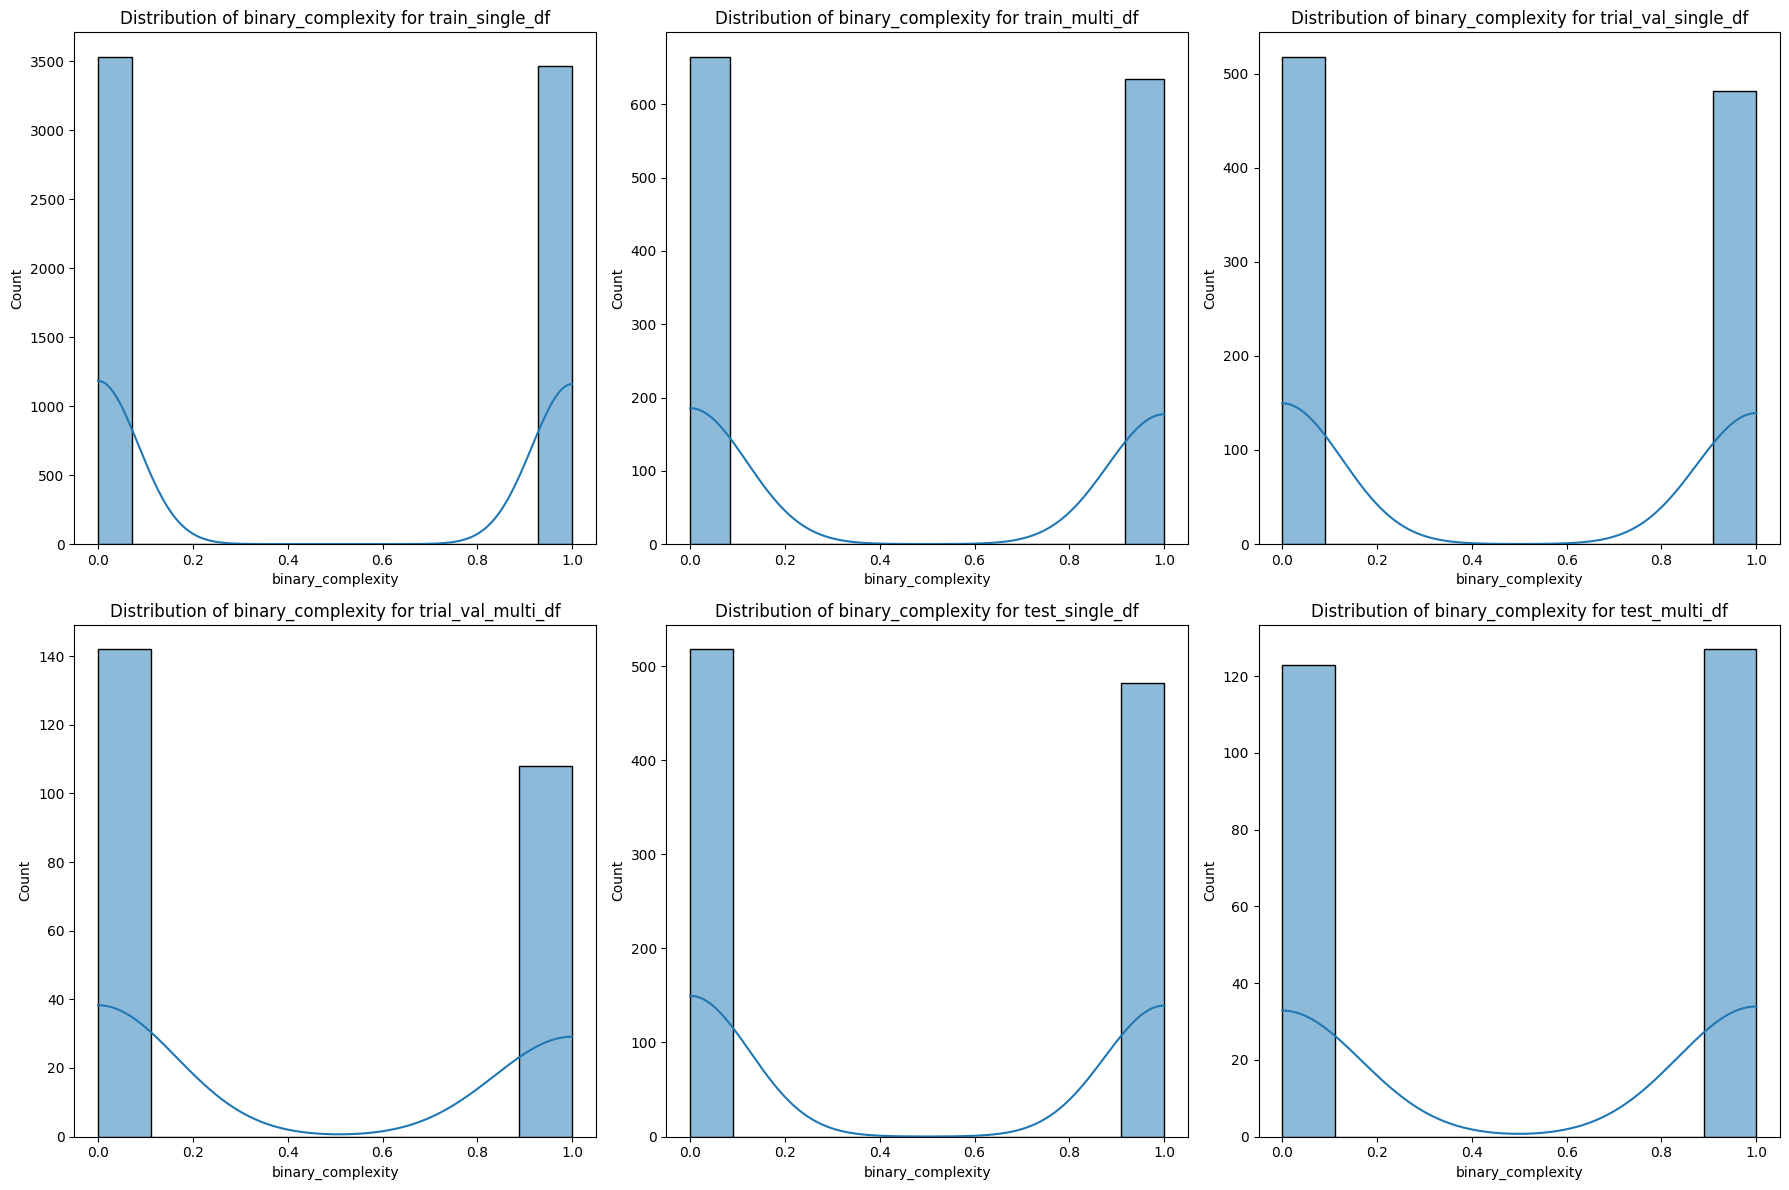

In [ ]:
dataframes = {
    "train_single_df": train_single_df,
    "train_multi_df": train_multi_df,
    "trial_val_single_df": trial_val_single_df,
    "trial_val_multi_df": trial_val_multi_df,
    "test_single_df": test_single_df,
    "test_multi_df": test_multi_df
}

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, (df_name, df) in enumerate(dataframes.items()):
  row = i // 3
  col = i % 3
  ax = axes[row, col]
  sns.histplot(df['binary_complexity'], kde=True, ax=ax)
  ax.set_title(f'Distribution of binary_complexity for {df_name}')
  ax.set_xlabel('binary_complexity')

plt.tight_layout()
plt.show()


In [ ]:
train_single_75th = train_single_df['complexity'].quantile(0.75)
train_multi_75th = train_multi_df['complexity'].quantile(0.75)

print("75th percentile (single-track):", train_single_75th)
print("75th percentile (multi-track):", train_multi_75th)

def binarize_complexity_75th(value, threshold):
    """
    Returns 0 if 'value' <= threshold, else 1.
    """
    if value <= threshold:
        return 0
    else:
        return 1

train_single_df['binary_complexity_75th_split'] = train_single_df['complexity'].apply(
    lambda x: binarize_complexity_75th(x, train_single_75th)
)
trial_val_single_df['binary_complexity_75th_split'] = trial_val_single_df['complexity'].apply(
    lambda x: binarize_complexity_75th(x, train_single_75th)
)
test_single_df['binary_complexity_75th_split'] = test_single_df['complexity'].apply(
    lambda x: binarize_complexity_75th(x, train_single_75th)
)

train_multi_df['binary_complexity_75th_split'] = train_multi_df['complexity'].apply(
    lambda x: binarize_complexity_75th(x, train_multi_75th)
)
trial_val_multi_df['binary_complexity_75th_split'] = trial_val_multi_df['complexity'].apply(
    lambda x: binarize_complexity_75th(x, train_multi_75th)
)
test_multi_df['binary_complexity_75th_split'] = test_multi_df['complexity'].apply(
    lambda x: binarize_complexity_75th(x, train_multi_75th)
)

print("\nDistribution of 'binary_complexity_75th_split' in train_single_df:")
print(train_single_df['binary_complexity_75th_split'].value_counts())

print("\nDistribution of 'binary_complexity_75th_split' in train_multi_df:")
print(train_multi_df['binary_complexity_75th_split'].value_counts())


75th percentile (single-track): 0.375
75th percentile (multi-track): 0.5294117647058824

Distribution of 'binary_complexity_75th_split' in train_single_df:
binary_complexity_75th_split
0    5326
1    1674
Name: count, dtype: int64

Distribution of 'binary_complexity_75th_split' in train_multi_df:
binary_complexity_75th_split
0    976
1    324
Name: count, dtype: int64


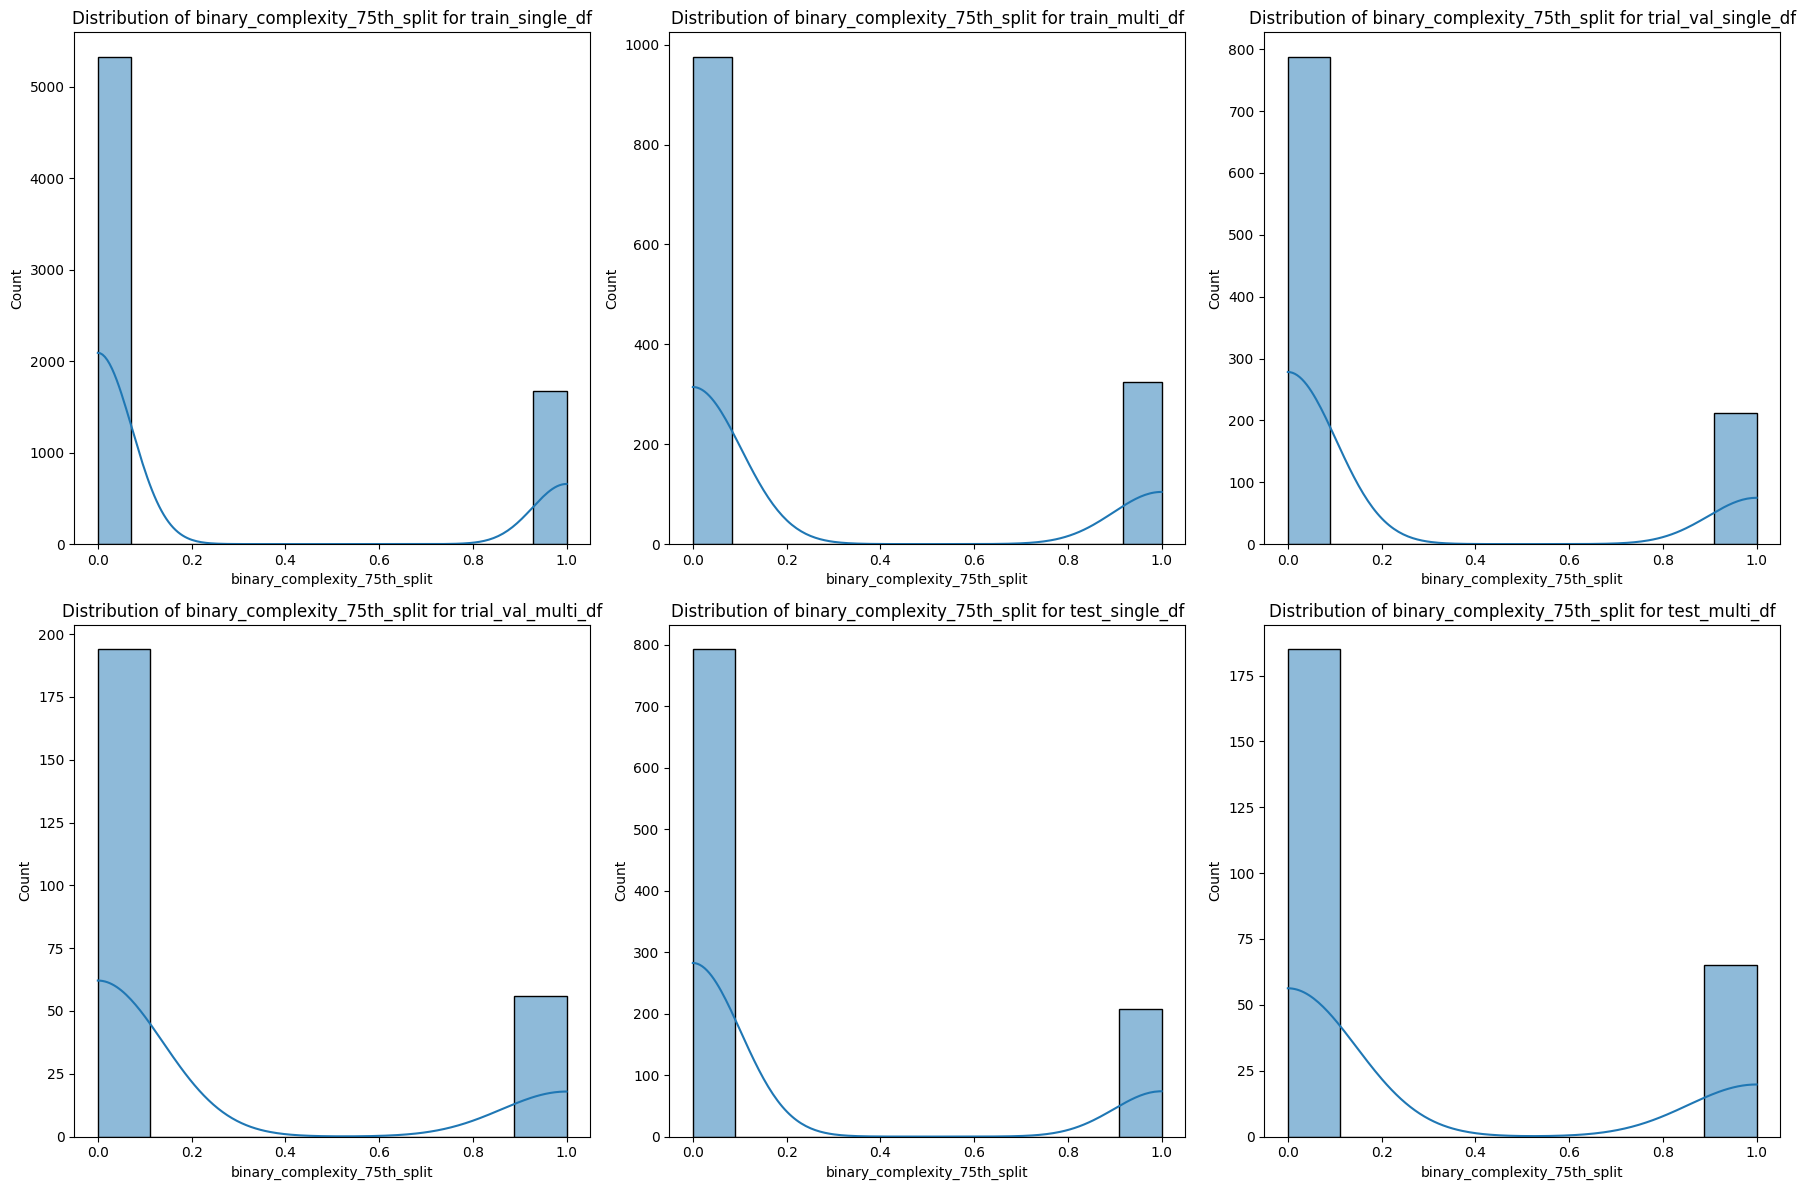

In [ ]:
dataframes = {
    "train_single_df": train_single_df,
    "train_multi_df": train_multi_df,
    "trial_val_single_df": trial_val_single_df,
    "trial_val_multi_df": trial_val_multi_df,
    "test_single_df": test_single_df,
    "test_multi_df": test_multi_df
}

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, (df_name, df) in enumerate(dataframes.items()):
  row = i // 3
  col = i % 3
  ax = axes[row, col]
  sns.histplot(df['binary_complexity_75th_split'], kde=True, ax=ax)
  ax.set_title(f'Distribution of binary_complexity_75th_split for {df_name}')
  ax.set_xlabel('binary_complexity_75th_split')

plt.tight_layout()
plt.show()


In [ ]:
!ls -R /content/drive/MyDrive/266-final/data/266-comp-lex-master/

/content/drive/MyDrive/266-final/data/266-comp-lex-master/:
fe-test-labels	fe-train  fe-trial-val	test-labels  train  trial

/content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-test-labels:
test_multi_df.csv  test_single_df.csv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-train:
train_multi_df.csv  train_single_df.csv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-trial-val:
trial_val_multi_df.csv	trial_val_single_df.csv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/test-labels:
lcp_multi_test.tsv  lcp_single_test.tsv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/train:
lcp_multi_train.tsv  lcp_single_train.tsv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/trial:
lcp_multi_trial.tsv  lcp_single_trial.tsv


In [ ]:
# verify column headers

dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]
for df in dataframes:
  print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            7000 non-null   object 
 1   corpus                        7000 non-null   object 
 2   sentence                      7000 non-null   object 
 3   token                         6995 non-null   object 
 4   complexity                    7000 non-null   float64
 5   is_duplicated                 7000 non-null   object 
 6   sentence_no_contractions      7000 non-null   object 
 7   contraction_expanded          7000 non-null   bool   
 8   pos_sequence                  7000 non-null   object 
 9   dep_sequence                  7000 non-null   object 
 10  morph_sequence                7000 non-null   object 
 11  morph_complexity              7000 non-null   float64
 12  binary_complexity             7000 non-null   int64  
 13  bin

In [ ]:
# inspect each df

dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]
for df in dataframes:
  print(df.head())

                               id    corpus                                           sentence            token  complexity is_duplicated                           sentence_no_contractions  contraction_expanded                                       pos_sequence                                       dep_sequence                                     morph_sequence  morph_complexity  binary_complexity  binary_complexity_75th_split
0  3IQ9O0AYW6ZPOAQ7VNRXLNM4D1DITZ    biomed  The development of sexually dimorphic reproduc...           organs    0.250000            {}  The development of sexually dimorphic reproduc...                 False  [DET, NOUN, ADP, ADV, ADJ, ADJ, NOUN, AUX, DET...  [det, nsubj, prep, advmod, amod, amod, pobj, R...  [(Definite=Def, PronType=Art), (Number=Sing), ...          1.200000                  0                             0
1  3PA41K45VN4U7YG4VFEGPOVYAII7PP    biomed  We find that the majority of the olfactory rec...            usage    0.382353            {} 

In [ ]:
dataframes = {
    "train_single_df": train_single_df,
    "train_multi_df": train_multi_df,
    "trial_val_single_df": trial_val_single_df,
    "trial_val_multi_df": trial_val_multi_df,
    "test_single_df": test_single_df,
    "test_multi_df": test_multi_df
}

for df_name, df in dataframes.items():
    print(f"\n=== {df_name} ===")
    print(df['binary_complexity'].value_counts())



=== train_single_df ===
binary_complexity
0    3534
1    3466
Name: count, dtype: int64

=== train_multi_df ===
binary_complexity
0    665
1    635
Name: count, dtype: int64

=== trial_val_single_df ===
binary_complexity
0    518
1    482
Name: count, dtype: int64

=== trial_val_multi_df ===
binary_complexity
0    142
1    108
Name: count, dtype: int64

=== test_single_df ===
binary_complexity
0    518
1    482
Name: count, dtype: int64

=== test_multi_df ===
binary_complexity
1    127
0    123
Name: count, dtype: int64


### Create Concatenated and Alternating Features

In [ ]:
def pos_method1_concat(row):
    """
    Row-level function for Method 1 (POS):
    sentence_no_contractions + " [" + comma-separated pos_sequence + "]"
    """
    sentence = row['sentence_no_contractions']
    tags = row['pos_sequence']  # list of POS
    if not isinstance(tags, list):
        return sentence  # gracefully handle missing or non-list
    joined_tags = ", ".join(tags)
    return f"{sentence} [{joined_tags}]"

def pos_method2_concat(row):
    """
    Row-level function for Method 2 (POS):
    Interleave tokens with [POS_TAG].
    """
    sentence = row['sentence_no_contractions']
    tags = row['pos_sequence']
    if not isinstance(tags, list):
        return sentence
    tokens = sentence.split()
    interleaved = []
    for tok, pos in zip(tokens, tags):
        interleaved.append(f"{tok} [{pos}]")
    leftover_tokens = tokens[len(tags):]
    interleaved.extend(leftover_tokens)
    return " ".join(interleaved)

def create_pos_method1(df):
    """Creates column snc_pos_seq using pos_method1_concat."""
    df['snc_pos_seq'] = df.apply(pos_method1_concat, axis=1)

def create_pos_method2(df):
    """Creates column snc_pos_alt using pos_method2_concat."""
    df['snc_pos_alt'] = df.apply(pos_method2_concat, axis=1)

for df_name, df in dataframes.items():
    create_pos_method1(df)   # => snc_pos_seq
    create_pos_method2(df)   # => snc_pos_alt

In [ ]:
def morph_method1_concat(row):
    """
    Row-level function for Method 1 (Morph):
    sentence_no_contractions + " [" + comma-separated morph_sequence + "]"
    Where each morph is parenthesized like (Number=Sing), etc.
    """
    sentence = row['sentence_no_contractions']
    morphs = row['morph_sequence']  # list of morph feature strings
    if not isinstance(morphs, list):
        return sentence
    joined_morphs = ", ".join(f"({m})" for m in morphs)
    return f"{sentence} [{joined_morphs}]"

def morph_method2_concat(row):
    """
    Row-level function for Method 2 (Morph):
    Interleave tokens with [({morph})].
    Example:  "bread [(Number=Sing)] dough [(Degree=Pos)] ..."
    """
    sentence = row['sentence_no_contractions']
    morphs = row['morph_sequence']
    if not isinstance(morphs, list):
        return sentence

    tokens = sentence.split()
    interleaved = []
    for tok, morph in zip(tokens, morphs):
        interleaved.append(f"{tok} [({morph})]")
    leftover_tokens = tokens[len(morphs):]
    interleaved.extend(leftover_tokens)
    return " ".join(interleaved)

def create_morph_method1(df):
    """Creates column snc_morph_seq using morph_method1_concat."""
    df['snc_morph_seq'] = df.apply(morph_method1_concat, axis=1)

def create_morph_method2(df):
    """Creates column snc_morph_alt using morph_method2_concat."""
    df['snc_morph_alt'] = df.apply(morph_method2_concat, axis=1)

for df_name, df in dataframes.items():
    create_morph_method1(df)  # => snc_morph_seq
    create_morph_method2(df)  # => snc_morph_alt

In [ ]:
def dep_method1_concat(row):
    """
    Row-level function for Method 1 (Dependency):
    sentence_no_contractions + " [" + comma-separated dep_sequence + "]"
    """
    sentence = row['sentence_no_contractions']
    deps = row['dep_sequence']  # list of dependency tags
    if not isinstance(deps, list):
        return sentence
    joined_deps = ", ".join(deps)
    return f"{sentence} [{joined_deps}]"

def dep_method2_concat(row):
    """
    Row-level function for Method 2 (Dependency):
    Interleave tokens with [DEP_TAG].
    """
    sentence = row['sentence_no_contractions']
    deps = row['dep_sequence']
    if not isinstance(deps, list):
        return sentence

    tokens = sentence.split()
    interleaved = []
    for tok, dep in zip(tokens, deps):
        interleaved.append(f"{tok} [{dep}]")
    leftover_tokens = tokens[len(deps):]
    interleaved.extend(leftover_tokens)
    return " ".join(interleaved)

def create_dep_method1(df):
    """Creates column snc_dep_seq using dep_method1_concat."""
    df['snc_dep_seq'] = df.apply(dep_method1_concat, axis=1)

def create_dep_method2(df):
    """Creates column snc_dep_alt using dep_method2_concat."""
    df['snc_dep_alt'] = df.apply(dep_method2_concat, axis=1)

for df_name, df in dataframes.items():
    create_dep_method1(df)   # => snc_dep_seq
    create_dep_method2(df)   # => snc_dep_alt (optional if needed)

In [ ]:
def morph_complexity_concat(row):
    """
    Row-level function for appending the numeric 'morph_complexity'
    to the end of sentence_no_contractions.
    """
    sentence = row['sentence_no_contractions']
    mc = row['morph_complexity']
    if pd.isna(mc):
        return sentence  # handle missing
    return f"{sentence} {mc}"

def create_morph_complexity_value(df):
    """
    - For each row, produce:
         sentence_no_contractions + " " + str(morph_complexity)
    - Store result in 'snc_morph_complexity_value'.
    """
    df['snc_morph_complexity_value'] = df.apply(morph_complexity_concat, axis=1)

for df_name, df in dataframes.items():
    create_morph_complexity_value(df)  # => snc_morph_complexity_value

In [ ]:
# verify column headers

dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]
for df in dataframes:
  print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            7000 non-null   object 
 1   corpus                        7000 non-null   object 
 2   sentence                      7000 non-null   object 
 3   token                         6995 non-null   object 
 4   complexity                    7000 non-null   float64
 5   is_duplicated                 7000 non-null   object 
 6   sentence_no_contractions      7000 non-null   object 
 7   contraction_expanded          7000 non-null   bool   
 8   pos_sequence                  7000 non-null   object 
 9   dep_sequence                  7000 non-null   object 
 10  morph_sequence                7000 non-null   object 
 11  morph_complexity              7000 non-null   float64
 12  binary_complexity             7000 non-null   int64  
 13  bin

In [ ]:
# inspect each df

dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]
for df in dataframes:
  print(df.head())

                               id    corpus                                           sentence            token  complexity is_duplicated                           sentence_no_contractions  contraction_expanded                                       pos_sequence                                       dep_sequence                                     morph_sequence  morph_complexity  binary_complexity  binary_complexity_75th_split                                        snc_pos_seq                                        snc_pos_alt                                      snc_morph_seq                                      snc_morph_alt                                        snc_dep_seq                                        snc_dep_alt                         snc_morph_complexity_value
0  3IQ9O0AYW6ZPOAQ7VNRXLNM4D1DITZ    biomed  The development of sexually dimorphic reproduc...           organs    0.250000            {}  The development of sexually dimorphic reproduc...                 False  

In [ ]:
dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]

for df in dataframes:
    if hasattr(df, 'columns') and 'corpus' in df.columns:
        print(df[df['corpus'] == 'biomed'].head())
    else:
        pass

                                id  corpus                                           sentence      token  complexity is_duplicated                           sentence_no_contractions  contraction_expanded                                       pos_sequence                                       dep_sequence                                     morph_sequence  morph_complexity  binary_complexity  binary_complexity_75th_split                                        snc_pos_seq                                        snc_pos_alt                                      snc_morph_seq                                      snc_morph_alt                                        snc_dep_seq                                        snc_dep_alt                         snc_morph_complexity_value
0   3IQ9O0AYW6ZPOAQ7VNRXLNM4D1DITZ  biomed  The development of sexually dimorphic reproduc...     organs    0.250000            {}  The development of sexually dimorphic reproduc...                 False  [DET, NOUN, AD

In [ ]:
dataframes = [train_single_df, train_multi_df, trial_val_single_df, trial_val_multi_df, test_single_df, test_multi_df]

for df in dataframes:
    if hasattr(df, 'columns') and 'corpus' in df.columns:
        print(df[df['corpus'] == 'europarl'].head())
    else:
        pass

                                id    corpus                                           sentence            token  complexity is_duplicated                           sentence_no_contractions  contraction_expanded                                       pos_sequence                                       dep_sequence                                     morph_sequence  morph_complexity  binary_complexity  binary_complexity_75th_split                                        snc_pos_seq                                        snc_pos_alt                                      snc_morph_seq                                      snc_morph_alt                                        snc_dep_seq                                        snc_dep_alt                         snc_morph_complexity_value
3   3VJ4PFXFJ37PI5MYJ4PU9LKNJ9SUAF  europarl  The Taiwanese Government has informed the Coun...  representations    0.315789            {}  The Taiwanese Government has informed the Coun...                 False

Processing train_single_df on 'newly created columns'...
Processing train_multi_df on 'newly created columns'...
Processing trial_val_single_df on 'newly created columns'...
Processing trial_val_multi_df on 'newly created columns'...
Processing test_single_df on 'newly created columns'...
Processing test_multi_df on 'newly created columns'...
Analysis (NO CONTRACTIONS) saved to: /content/drive/MyDrive/266-final/results/sentence_span_analysis_no_contractions.csv


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the sa

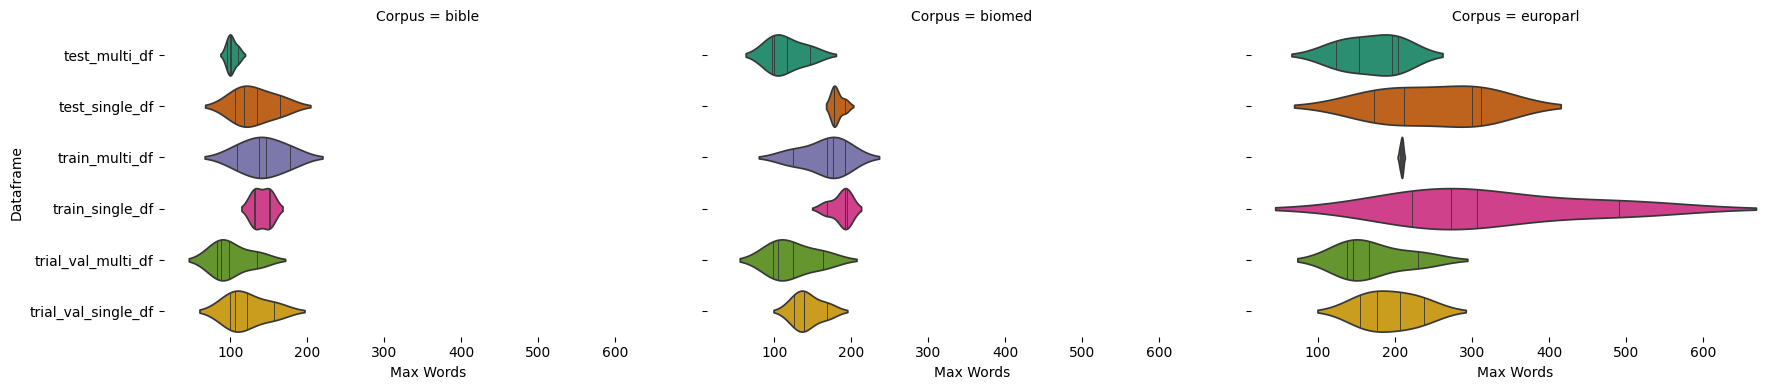

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

def analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs_dict):
    results = []

    for df_name, df in dfs_dict.items():
        print(f"Processing {df_name} on 'newly created columns'...")
        df = df.copy()

        q1 = df['complexity'].quantile(0.25)
        q2 = df['complexity'].quantile(0.50)
        q3 = df['complexity'].quantile(0.75)

        def get_quartile(x):
            if x <= q1:
                return 'Q1'
            elif x <= q2:
                return 'Q2'
            elif x <= q3:
                return 'Q3'
            else:
                return 'Q4'

        df['quartile'] = df['complexity'].apply(get_quartile)

        def compute_span_metrics_no_contracts(sentence):
            if pd.isna(sentence):
                return pd.Series({'word_count': 0, 'char_count': 0, 'avg_word_len': 0})

            words = tokenizer.tokenize(sentence)
            word_count = len(words)
            char_count = len(sentence)
            avg_word_len = np.mean([len(w) for w in words]) if word_count > 0 else 0

            return pd.Series({
                'word_count': word_count,
                'char_count': char_count,
                'avg_word_len': avg_word_len
            })

        span_metrics_nc = df['snc_pos_seq'].apply(compute_span_metrics_no_contracts)
        df = pd.concat([df, span_metrics_nc], axis=1)

        corpus_col = 'corpus'
        for corpus_name, corpus_df in df.groupby(corpus_col):
            for quartile, quartile_df in corpus_df.groupby('quartile'):
                complexity_range = f"{quartile_df['complexity'].min():.3f}-{quartile_df['complexity'].max():.3f}"
                stats = {
                    'Dataframe': df_name,
                    'Corpus': corpus_name,
                    'Quartile': quartile,
                    'Complexity Range': complexity_range,
                    'Count': len(quartile_df),
                    'Avg Words': quartile_df['word_count'].mean(),
                    'Median Words': quartile_df['word_count'].median(),
                    'Min Words': quartile_df['word_count'].min(),
                    'Max Words': quartile_df['word_count'].max(),
                    'Std Words': quartile_df['word_count'].std(),
                    'Avg Chars': quartile_df['char_count'].mean(),
                    'Avg Word Len': quartile_df['avg_word_len'].mean()
                }
                results.append(stats)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(['Dataframe', 'Corpus', 'Quartile'])
    return results_df


dfs = {
    'train_single_df': train_single_df,
    'train_multi_df': train_multi_df,
    'trial_val_single_df': trial_val_single_df,
    'trial_val_multi_df': trial_val_multi_df,
    'test_single_df': test_single_df,
    'test_multi_df': test_multi_df
}

span_analysis_nc = analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
# display(span_analysis_nc)

results_path_nc = os.path.join(dir_results, 'sentence_span_analysis_no_contractions.csv')
span_analysis_nc.to_csv(results_path_nc, index=False)
print(f"Analysis (NO CONTRACTIONS) saved to: {results_path_nc}")

g = sns.FacetGrid(span_analysis_nc, col="Corpus", col_wrap=3, height=4, aspect=1.5)
g.map(sns.violinplot, "Max Words", "Dataframe", inner='stick', palette='Dark2')
g.despine(top=True, right=True, bottom=True, left=True)
plt.tight_layout()
plt.show()


Processing train_single_df on 'newly created columns'...
Processing train_multi_df on 'newly created columns'...
Processing trial_val_single_df on 'newly created columns'...
Processing trial_val_multi_df on 'newly created columns'...
Processing test_single_df on 'newly created columns'...
Processing test_multi_df on 'newly created columns'...
Analysis (NO CONTRACTIONS) saved to: /content/drive/MyDrive/266-final/results/sentence_span_analysis_no_contractions.csv


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the sa

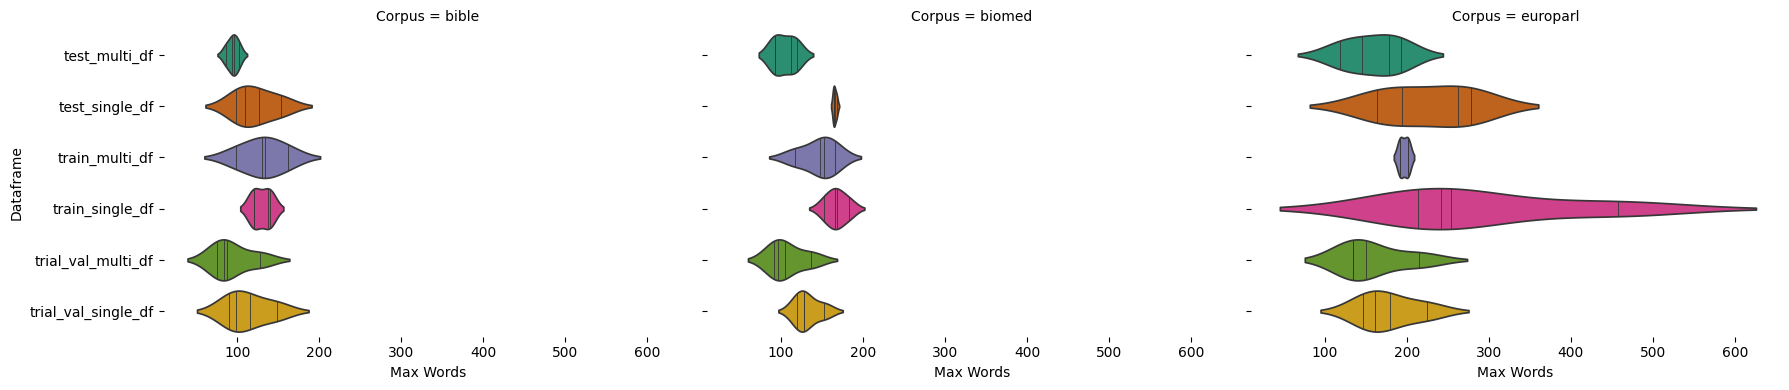

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

def analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs_dict):
    results = []

    for df_name, df in dfs_dict.items():
        print(f"Processing {df_name} on 'newly created columns'...")
        df = df.copy()

        q1 = df['complexity'].quantile(0.25)
        q2 = df['complexity'].quantile(0.50)
        q3 = df['complexity'].quantile(0.75)

        def get_quartile(x):
            if x <= q1:
                return 'Q1'
            elif x <= q2:
                return 'Q2'
            elif x <= q3:
                return 'Q3'
            else:
                return 'Q4'

        df['quartile'] = df['complexity'].apply(get_quartile)

        def compute_span_metrics_no_contracts(sentence):
            if pd.isna(sentence):
                return pd.Series({'word_count': 0, 'char_count': 0, 'avg_word_len': 0})

            words = tokenizer.tokenize(sentence)
            word_count = len(words)
            char_count = len(sentence)
            avg_word_len = np.mean([len(w) for w in words]) if word_count > 0 else 0

            return pd.Series({
                'word_count': word_count,
                'char_count': char_count,
                'avg_word_len': avg_word_len
            })

        span_metrics_nc = df['snc_pos_alt'].apply(compute_span_metrics_no_contracts)
        df = pd.concat([df, span_metrics_nc], axis=1)

        corpus_col = 'corpus'
        for corpus_name, corpus_df in df.groupby(corpus_col):
            for quartile, quartile_df in corpus_df.groupby('quartile'):
                complexity_range = f"{quartile_df['complexity'].min():.3f}-{quartile_df['complexity'].max():.3f}"
                stats = {
                    'Dataframe': df_name,
                    'Corpus': corpus_name,
                    'Quartile': quartile,
                    'Complexity Range': complexity_range,
                    'Count': len(quartile_df),
                    'Avg Words': quartile_df['word_count'].mean(),
                    'Median Words': quartile_df['word_count'].median(),
                    'Min Words': quartile_df['word_count'].min(),
                    'Max Words': quartile_df['word_count'].max(),
                    'Std Words': quartile_df['word_count'].std(),
                    'Avg Chars': quartile_df['char_count'].mean(),
                    'Avg Word Len': quartile_df['avg_word_len'].mean()
                }
                results.append(stats)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(['Dataframe', 'Corpus', 'Quartile'])
    return results_df


dfs = {
    'train_single_df': train_single_df,
    'train_multi_df': train_multi_df,
    'trial_val_single_df': trial_val_single_df,
    'trial_val_multi_df': trial_val_multi_df,
    'test_single_df': test_single_df,
    'test_multi_df': test_multi_df
}

span_analysis_nc = analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
# display(span_analysis_nc)

results_path_nc = os.path.join(dir_results, 'sentence_span_analysis_no_contractions.csv')
span_analysis_nc.to_csv(results_path_nc, index=False)
print(f"Analysis (NO CONTRACTIONS) saved to: {results_path_nc}")

g = sns.FacetGrid(span_analysis_nc, col="Corpus", col_wrap=3, height=4, aspect=1.5)
g.map(sns.violinplot, "Max Words", "Dataframe", inner='stick', palette='Dark2')
g.despine(top=True, right=True, bottom=True, left=True)
plt.tight_layout()
plt.show()


Processing train_single_df on 'newly created columns'...
Processing train_multi_df on 'newly created columns'...
Processing trial_val_single_df on 'newly created columns'...
Processing trial_val_multi_df on 'newly created columns'...
Processing test_single_df on 'newly created columns'...
Processing test_multi_df on 'newly created columns'...
Analysis (NO CONTRACTIONS) saved to: /content/drive/MyDrive/266-final/results/sentence_span_analysis_no_contractions.csv


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the sa

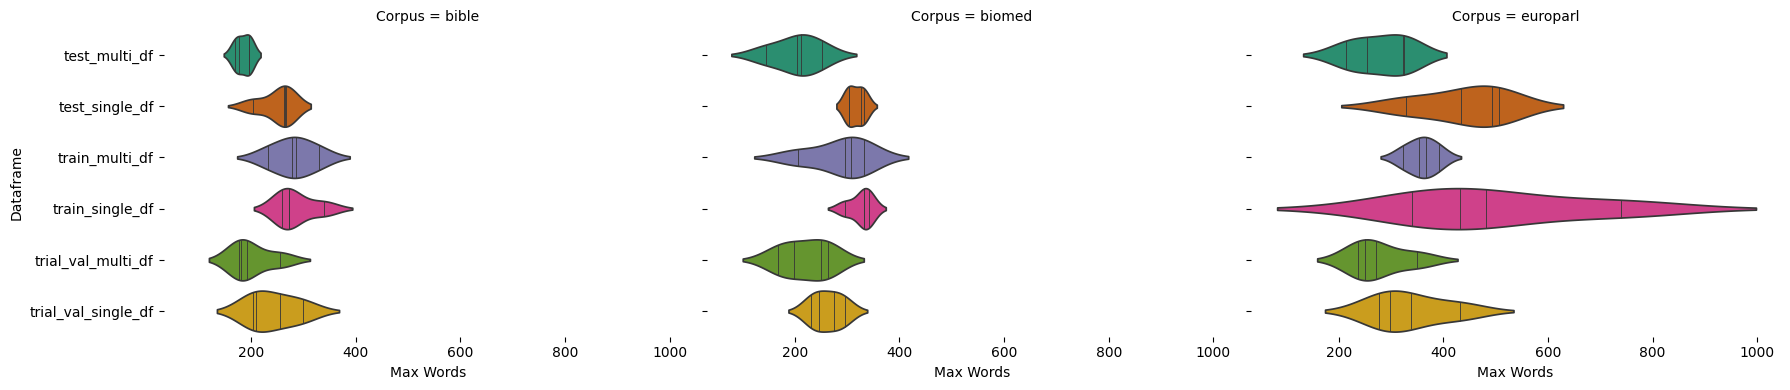

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

def analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs_dict):
    results = []

    for df_name, df in dfs_dict.items():
        print(f"Processing {df_name} on 'newly created columns'...")
        df = df.copy()

        q1 = df['complexity'].quantile(0.25)
        q2 = df['complexity'].quantile(0.50)
        q3 = df['complexity'].quantile(0.75)

        def get_quartile(x):
            if x <= q1:
                return 'Q1'
            elif x <= q2:
                return 'Q2'
            elif x <= q3:
                return 'Q3'
            else:
                return 'Q4'

        df['quartile'] = df['complexity'].apply(get_quartile)

        def compute_span_metrics_no_contracts(sentence):
            if pd.isna(sentence):
                return pd.Series({'word_count': 0, 'char_count': 0, 'avg_word_len': 0})

            words = tokenizer.tokenize(sentence)
            word_count = len(words)
            char_count = len(sentence)
            avg_word_len = np.mean([len(w) for w in words]) if word_count > 0 else 0

            return pd.Series({
                'word_count': word_count,
                'char_count': char_count,
                'avg_word_len': avg_word_len
            })

        span_metrics_nc = df['snc_morph_seq'].apply(compute_span_metrics_no_contracts)
        df = pd.concat([df, span_metrics_nc], axis=1)

        corpus_col = 'corpus'
        for corpus_name, corpus_df in df.groupby(corpus_col):
            for quartile, quartile_df in corpus_df.groupby('quartile'):
                complexity_range = f"{quartile_df['complexity'].min():.3f}-{quartile_df['complexity'].max():.3f}"
                stats = {
                    'Dataframe': df_name,
                    'Corpus': corpus_name,
                    'Quartile': quartile,
                    'Complexity Range': complexity_range,
                    'Count': len(quartile_df),
                    'Avg Words': quartile_df['word_count'].mean(),
                    'Median Words': quartile_df['word_count'].median(),
                    'Min Words': quartile_df['word_count'].min(),
                    'Max Words': quartile_df['word_count'].max(),
                    'Std Words': quartile_df['word_count'].std(),
                    'Avg Chars': quartile_df['char_count'].mean(),
                    'Avg Word Len': quartile_df['avg_word_len'].mean()
                }
                results.append(stats)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(['Dataframe', 'Corpus', 'Quartile'])
    return results_df


dfs = {
    'train_single_df': train_single_df,
    'train_multi_df': train_multi_df,
    'trial_val_single_df': trial_val_single_df,
    'trial_val_multi_df': trial_val_multi_df,
    'test_single_df': test_single_df,
    'test_multi_df': test_multi_df
}

span_analysis_nc = analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
# display(span_analysis_nc)

results_path_nc = os.path.join(dir_results, 'sentence_span_analysis_no_contractions.csv')
span_analysis_nc.to_csv(results_path_nc, index=False)
print(f"Analysis (NO CONTRACTIONS) saved to: {results_path_nc}")

g = sns.FacetGrid(span_analysis_nc, col="Corpus", col_wrap=3, height=4, aspect=1.5)
g.map(sns.violinplot, "Max Words", "Dataframe", inner='stick', palette='Dark2')
g.despine(top=True, right=True, bottom=True, left=True)
plt.tight_layout()
plt.show()


Processing train_single_df on 'newly created columns'...
Processing train_multi_df on 'newly created columns'...
Processing trial_val_single_df on 'newly created columns'...
Processing trial_val_multi_df on 'newly created columns'...
Processing test_single_df on 'newly created columns'...
Processing test_multi_df on 'newly created columns'...
Analysis (NO CONTRACTIONS) saved to: /content/drive/MyDrive/266-final/results/sentence_span_analysis_no_contractions.csv


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the sa

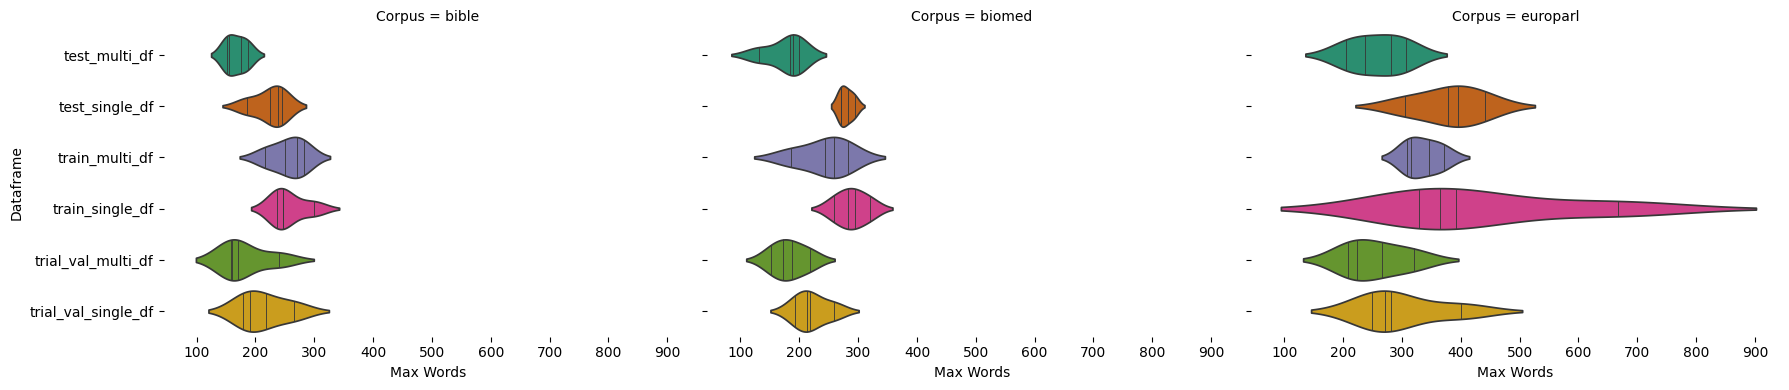

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

def analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs_dict):
    results = []

    for df_name, df in dfs_dict.items():
        print(f"Processing {df_name} on 'newly created columns'...")
        df = df.copy()

        q1 = df['complexity'].quantile(0.25)
        q2 = df['complexity'].quantile(0.50)
        q3 = df['complexity'].quantile(0.75)

        def get_quartile(x):
            if x <= q1:
                return 'Q1'
            elif x <= q2:
                return 'Q2'
            elif x <= q3:
                return 'Q3'
            else:
                return 'Q4'

        df['quartile'] = df['complexity'].apply(get_quartile)

        def compute_span_metrics_no_contracts(sentence):
            if pd.isna(sentence):
                return pd.Series({'word_count': 0, 'char_count': 0, 'avg_word_len': 0})

            words = tokenizer.tokenize(sentence)
            word_count = len(words)
            char_count = len(sentence)
            avg_word_len = np.mean([len(w) for w in words]) if word_count > 0 else 0

            return pd.Series({
                'word_count': word_count,
                'char_count': char_count,
                'avg_word_len': avg_word_len
            })

        span_metrics_nc = df['snc_morph_alt'].apply(compute_span_metrics_no_contracts)
        df = pd.concat([df, span_metrics_nc], axis=1)

        corpus_col = 'corpus'
        for corpus_name, corpus_df in df.groupby(corpus_col):
            for quartile, quartile_df in corpus_df.groupby('quartile'):
                complexity_range = f"{quartile_df['complexity'].min():.3f}-{quartile_df['complexity'].max():.3f}"
                stats = {
                    'Dataframe': df_name,
                    'Corpus': corpus_name,
                    'Quartile': quartile,
                    'Complexity Range': complexity_range,
                    'Count': len(quartile_df),
                    'Avg Words': quartile_df['word_count'].mean(),
                    'Median Words': quartile_df['word_count'].median(),
                    'Min Words': quartile_df['word_count'].min(),
                    'Max Words': quartile_df['word_count'].max(),
                    'Std Words': quartile_df['word_count'].std(),
                    'Avg Chars': quartile_df['char_count'].mean(),
                    'Avg Word Len': quartile_df['avg_word_len'].mean()
                }
                results.append(stats)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(['Dataframe', 'Corpus', 'Quartile'])
    return results_df


dfs = {
    'train_single_df': train_single_df,
    'train_multi_df': train_multi_df,
    'trial_val_single_df': trial_val_single_df,
    'trial_val_multi_df': trial_val_multi_df,
    'test_single_df': test_single_df,
    'test_multi_df': test_multi_df
}

span_analysis_nc = analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
# display(span_analysis_nc)

results_path_nc = os.path.join(dir_results, 'sentence_span_analysis_no_contractions.csv')
span_analysis_nc.to_csv(results_path_nc, index=False)
print(f"Analysis (NO CONTRACTIONS) saved to: {results_path_nc}")

g = sns.FacetGrid(span_analysis_nc, col="Corpus", col_wrap=3, height=4, aspect=1.5)
g.map(sns.violinplot, "Max Words", "Dataframe", inner='stick', palette='Dark2')
g.despine(top=True, right=True, bottom=True, left=True)
plt.tight_layout()
plt.show()


Processing train_single_df on 'newly created columns'...
Processing train_multi_df on 'newly created columns'...
Processing trial_val_single_df on 'newly created columns'...
Processing trial_val_multi_df on 'newly created columns'...
Processing test_single_df on 'newly created columns'...
Processing test_multi_df on 'newly created columns'...
Analysis (NO CONTRACTIONS) saved to: /content/drive/MyDrive/266-final/results/sentence_span_analysis_no_contractions.csv


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the sa

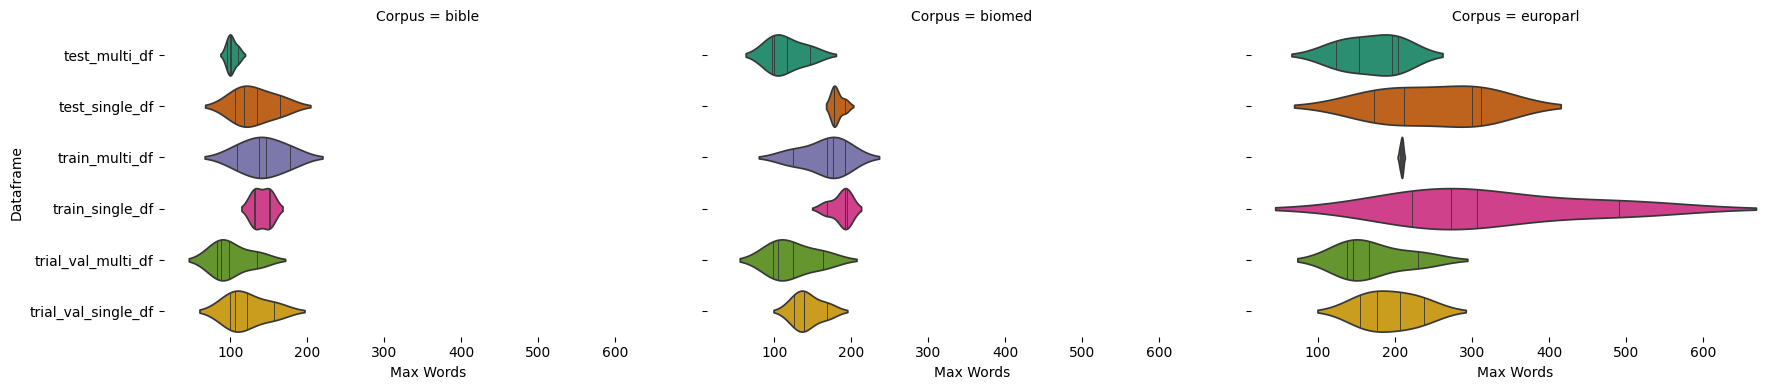

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

def analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs_dict):
    results = []

    for df_name, df in dfs_dict.items():
        print(f"Processing {df_name} on 'newly created columns'...")
        df = df.copy()

        q1 = df['complexity'].quantile(0.25)
        q2 = df['complexity'].quantile(0.50)
        q3 = df['complexity'].quantile(0.75)

        def get_quartile(x):
            if x <= q1:
                return 'Q1'
            elif x <= q2:
                return 'Q2'
            elif x <= q3:
                return 'Q3'
            else:
                return 'Q4'

        df['quartile'] = df['complexity'].apply(get_quartile)

        def compute_span_metrics_no_contracts(sentence):
            if pd.isna(sentence):
                return pd.Series({'word_count': 0, 'char_count': 0, 'avg_word_len': 0})

            words = tokenizer.tokenize(sentence)
            word_count = len(words)
            char_count = len(sentence)
            avg_word_len = np.mean([len(w) for w in words]) if word_count > 0 else 0

            return pd.Series({
                'word_count': word_count,
                'char_count': char_count,
                'avg_word_len': avg_word_len
            })

        span_metrics_nc = df['snc_dep_seq'].apply(compute_span_metrics_no_contracts)
        df = pd.concat([df, span_metrics_nc], axis=1)

        corpus_col = 'corpus'
        for corpus_name, corpus_df in df.groupby(corpus_col):
            for quartile, quartile_df in corpus_df.groupby('quartile'):
                complexity_range = f"{quartile_df['complexity'].min():.3f}-{quartile_df['complexity'].max():.3f}"
                stats = {
                    'Dataframe': df_name,
                    'Corpus': corpus_name,
                    'Quartile': quartile,
                    'Complexity Range': complexity_range,
                    'Count': len(quartile_df),
                    'Avg Words': quartile_df['word_count'].mean(),
                    'Median Words': quartile_df['word_count'].median(),
                    'Min Words': quartile_df['word_count'].min(),
                    'Max Words': quartile_df['word_count'].max(),
                    'Std Words': quartile_df['word_count'].std(),
                    'Avg Chars': quartile_df['char_count'].mean(),
                    'Avg Word Len': quartile_df['avg_word_len'].mean()
                }
                results.append(stats)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(['Dataframe', 'Corpus', 'Quartile'])
    return results_df


dfs = {
    'train_single_df': train_single_df,
    'train_multi_df': train_multi_df,
    'trial_val_single_df': trial_val_single_df,
    'trial_val_multi_df': trial_val_multi_df,
    'test_single_df': test_single_df,
    'test_multi_df': test_multi_df
}

span_analysis_nc = analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
# display(span_analysis_nc)

results_path_nc = os.path.join(dir_results, 'sentence_span_analysis_no_contractions.csv')
span_analysis_nc.to_csv(results_path_nc, index=False)
print(f"Analysis (NO CONTRACTIONS) saved to: {results_path_nc}")

g = sns.FacetGrid(span_analysis_nc, col="Corpus", col_wrap=3, height=4, aspect=1.5)
g.map(sns.violinplot, "Max Words", "Dataframe", inner='stick', palette='Dark2')
g.despine(top=True, right=True, bottom=True, left=True)
plt.tight_layout()
plt.show()


Processing train_single_df on 'newly created columns'...
Processing train_multi_df on 'newly created columns'...
Processing trial_val_single_df on 'newly created columns'...
Processing trial_val_multi_df on 'newly created columns'...
Processing test_single_df on 'newly created columns'...
Processing test_multi_df on 'newly created columns'...
Analysis (NO CONTRACTIONS) saved to: /content/drive/MyDrive/266-final/results/sentence_span_analysis_no_contractions.csv


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the sa

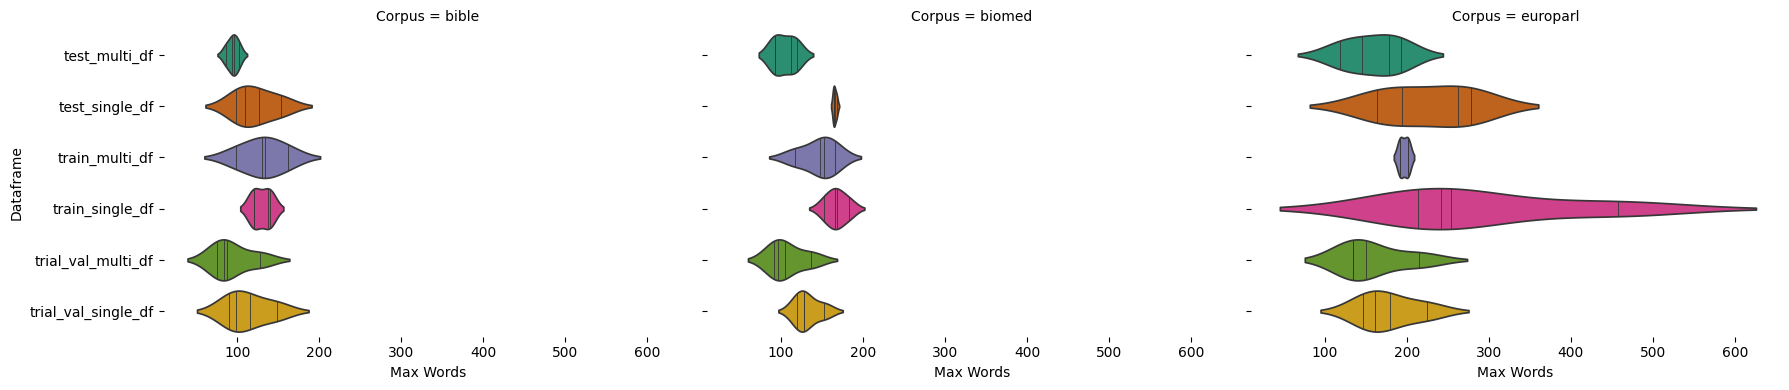

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

def analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs_dict):
    results = []

    for df_name, df in dfs_dict.items():
        print(f"Processing {df_name} on 'newly created columns'...")
        df = df.copy()

        q1 = df['complexity'].quantile(0.25)
        q2 = df['complexity'].quantile(0.50)
        q3 = df['complexity'].quantile(0.75)

        def get_quartile(x):
            if x <= q1:
                return 'Q1'
            elif x <= q2:
                return 'Q2'
            elif x <= q3:
                return 'Q3'
            else:
                return 'Q4'

        df['quartile'] = df['complexity'].apply(get_quartile)

        def compute_span_metrics_no_contracts(sentence):
            if pd.isna(sentence):
                return pd.Series({'word_count': 0, 'char_count': 0, 'avg_word_len': 0})

            words = tokenizer.tokenize(sentence)
            word_count = len(words)
            char_count = len(sentence)
            avg_word_len = np.mean([len(w) for w in words]) if word_count > 0 else 0

            return pd.Series({
                'word_count': word_count,
                'char_count': char_count,
                'avg_word_len': avg_word_len
            })

        span_metrics_nc = df['snc_dep_alt'].apply(compute_span_metrics_no_contracts)
        df = pd.concat([df, span_metrics_nc], axis=1)

        corpus_col = 'corpus'
        for corpus_name, corpus_df in df.groupby(corpus_col):
            for quartile, quartile_df in corpus_df.groupby('quartile'):
                complexity_range = f"{quartile_df['complexity'].min():.3f}-{quartile_df['complexity'].max():.3f}"
                stats = {
                    'Dataframe': df_name,
                    'Corpus': corpus_name,
                    'Quartile': quartile,
                    'Complexity Range': complexity_range,
                    'Count': len(quartile_df),
                    'Avg Words': quartile_df['word_count'].mean(),
                    'Median Words': quartile_df['word_count'].median(),
                    'Min Words': quartile_df['word_count'].min(),
                    'Max Words': quartile_df['word_count'].max(),
                    'Std Words': quartile_df['word_count'].std(),
                    'Avg Chars': quartile_df['char_count'].mean(),
                    'Avg Word Len': quartile_df['avg_word_len'].mean()
                }
                results.append(stats)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(['Dataframe', 'Corpus', 'Quartile'])
    return results_df


dfs = {
    'train_single_df': train_single_df,
    'train_multi_df': train_multi_df,
    'trial_val_single_df': trial_val_single_df,
    'trial_val_multi_df': trial_val_multi_df,
    'test_single_df': test_single_df,
    'test_multi_df': test_multi_df
}

span_analysis_nc = analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
# display(span_analysis_nc)

results_path_nc = os.path.join(dir_results, 'sentence_span_analysis_no_contractions.csv')
span_analysis_nc.to_csv(results_path_nc, index=False)
print(f"Analysis (NO CONTRACTIONS) saved to: {results_path_nc}")

g = sns.FacetGrid(span_analysis_nc, col="Corpus", col_wrap=3, height=4, aspect=1.5)
g.map(sns.violinplot, "Max Words", "Dataframe", inner='stick', palette='Dark2')
g.despine(top=True, right=True, bottom=True, left=True)
plt.tight_layout()
plt.show()


Processing train_single_df on 'newly created columns'...
Processing train_multi_df on 'newly created columns'...
Processing trial_val_single_df on 'newly created columns'...
Processing trial_val_multi_df on 'newly created columns'...
Processing test_single_df on 'newly created columns'...
Processing test_multi_df on 'newly created columns'...
Analysis (NO CONTRACTIONS) saved to: /content/drive/MyDrive/266-final/results/sentence_span_analysis_no_contractions.csv


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the sa

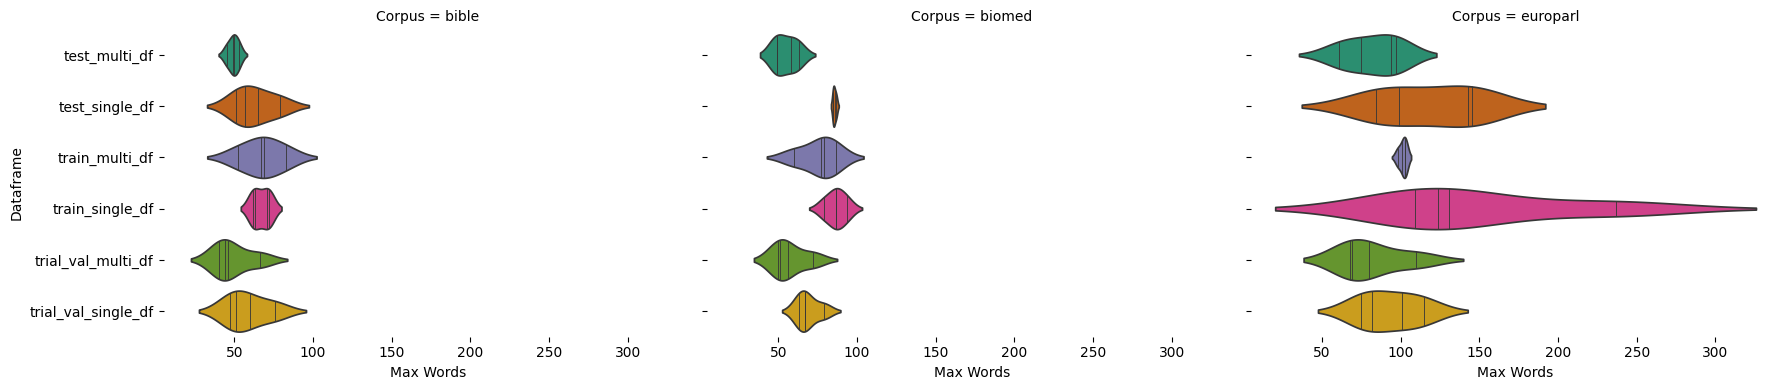

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

def analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs_dict):
    results = []

    for df_name, df in dfs_dict.items():
        print(f"Processing {df_name} on 'newly created columns'...")
        df = df.copy()

        q1 = df['complexity'].quantile(0.25)
        q2 = df['complexity'].quantile(0.50)
        q3 = df['complexity'].quantile(0.75)

        def get_quartile(x):
            if x <= q1:
                return 'Q1'
            elif x <= q2:
                return 'Q2'
            elif x <= q3:
                return 'Q3'
            else:
                return 'Q4'

        df['quartile'] = df['complexity'].apply(get_quartile)

        def compute_span_metrics_no_contracts(sentence):
            if pd.isna(sentence):
                return pd.Series({'word_count': 0, 'char_count': 0, 'avg_word_len': 0})

            words = tokenizer.tokenize(sentence)
            word_count = len(words)
            char_count = len(sentence)
            avg_word_len = np.mean([len(w) for w in words]) if word_count > 0 else 0

            return pd.Series({
                'word_count': word_count,
                'char_count': char_count,
                'avg_word_len': avg_word_len
            })

        span_metrics_nc = df['snc_morph_complexity_value'].apply(compute_span_metrics_no_contracts)
        df = pd.concat([df, span_metrics_nc], axis=1)

        corpus_col = 'corpus'
        for corpus_name, corpus_df in df.groupby(corpus_col):
            for quartile, quartile_df in corpus_df.groupby('quartile'):
                complexity_range = f"{quartile_df['complexity'].min():.3f}-{quartile_df['complexity'].max():.3f}"
                stats = {
                    'Dataframe': df_name,
                    'Corpus': corpus_name,
                    'Quartile': quartile,
                    'Complexity Range': complexity_range,
                    'Count': len(quartile_df),
                    'Avg Words': quartile_df['word_count'].mean(),
                    'Median Words': quartile_df['word_count'].median(),
                    'Min Words': quartile_df['word_count'].min(),
                    'Max Words': quartile_df['word_count'].max(),
                    'Std Words': quartile_df['word_count'].std(),
                    'Avg Chars': quartile_df['char_count'].mean(),
                    'Avg Word Len': quartile_df['avg_word_len'].mean()
                }
                results.append(stats)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(['Dataframe', 'Corpus', 'Quartile'])
    return results_df


dfs = {
    'train_single_df': train_single_df,
    'train_multi_df': train_multi_df,
    'trial_val_single_df': trial_val_single_df,
    'trial_val_multi_df': trial_val_multi_df,
    'test_single_df': test_single_df,
    'test_multi_df': test_multi_df
}

span_analysis_nc = analyze_sentence_spans_by_corpus_and_quartile_no_contracts(dfs)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
# display(span_analysis_nc)

results_path_nc = os.path.join(dir_results, 'sentence_span_analysis_no_contractions.csv')
span_analysis_nc.to_csv(results_path_nc, index=False)
print(f"Analysis (NO CONTRACTIONS) saved to: {results_path_nc}")

g = sns.FacetGrid(span_analysis_nc, col="Corpus", col_wrap=3, height=4, aspect=1.5)
g.map(sns.violinplot, "Max Words", "Dataframe", inner='stick', palette='Dark2')
g.despine(top=True, right=True, bottom=True, left=True)
plt.tight_layout()
plt.show()


### Save Dataframes as CSVs

In [ ]:
### Save Dataframes as CSVs

In [ ]:
!tree /content/drive/MyDrive/266-final/data/266-comp-lex-master/

/content/drive/MyDrive/266-final/data/266-comp-lex-master/
├── fe-test-labels
│   ├── test_multi_df.csv
│   └── test_single_df.csv
├── fe-train
│   ├── train_multi_df.csv
│   └── train_single_df.csv
├── fe-trial-val
│   ├── trial_val_multi_df.csv
│   └── trial_val_single_df.csv
├── test-labels
│   ├── lcp_multi_test.tsv
│   └── lcp_single_test.tsv
├── train
│   ├── lcp_multi_train.tsv
│   └── lcp_single_train.tsv
└── trial
    ├── lcp_multi_trial.tsv
    └── lcp_single_trial.tsv

6 directories, 12 files


In [ ]:
dataframes = {
    "train_single_df": train_single_df,
    "train_multi_df": train_multi_df,
    "trial_val_single_df": trial_val_single_df,
    "trial_val_multi_df": trial_val_multi_df,
    "test_single_df": test_single_df,
    "test_multi_df": test_multi_df
}

base_dir = "/content/drive/MyDrive/266-final/data/266-comp-lex-master/"

for df_name, df in dataframes.items():
    subdir = None
    if "train" in df_name:
      subdir = "fe-train"
    elif "trial_val" in df_name:
      subdir = "fe-trial-val"
    elif "test" in df_name:
      subdir = "fe-test-labels"

    if subdir:
      save_path = os.path.join(base_dir, subdir, f"{df_name}.csv")
      os.makedirs(os.path.dirname(save_path), exist_ok=True)
      df.to_csv(save_path, index=False)
      print(f"Saved {df_name} to {save_path}")


Saved train_single_df to /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-train/train_single_df.csv
Saved train_multi_df to /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-train/train_multi_df.csv
Saved trial_val_single_df to /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-trial-val/trial_val_single_df.csv
Saved trial_val_multi_df to /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-trial-val/trial_val_multi_df.csv
Saved test_single_df to /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-test-labels/test_single_df.csv
Saved test_multi_df to /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-test-labels/test_multi_df.csv


In [ ]:
df_names = [
    "train_single_df",
    "train_multi_df",
    "trial_val_single_df",
    "trial_val_multi_df",
    "test_single_df",
    "test_multi_df"
]

loaded_dataframes = {}

for df_name in df_names:
    if "train" in df_name:
        subdir = "fe-train"
    elif "trial_val" in df_name:
        subdir = "fe-trial-val"
    elif "test" in df_name:
        subdir = "fe-test-labels"
    else:
        subdir = None

    if subdir:
        read_path = os.path.join(dir_data, subdir, f"{df_name}.csv")
        loaded_df = pd.read_csv(read_path)
        loaded_dataframes[df_name] = loaded_df
        print(f"Loaded {df_name} from {read_path}")

for df_name, df in loaded_dataframes.items():
    print(f"\n>>> {df_name} shape: {df.shape}")
    if 'binary_complexity' in df.columns:
        print(df['binary_complexity'].value_counts())


Loaded train_single_df from /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-train/train_single_df.csv
Loaded train_multi_df from /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-train/train_multi_df.csv
Loaded trial_val_single_df from /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-trial-val/trial_val_single_df.csv
Loaded trial_val_multi_df from /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-trial-val/trial_val_multi_df.csv
Loaded test_single_df from /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-test-labels/test_single_df.csv
Loaded test_multi_df from /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-test-labels/test_multi_df.csv

>>> train_single_df shape: (7000, 21)
binary_complexity
0    3534
1    3466
Name: count, dtype: int64

>>> train_multi_df shape: (1300, 21)
binary_complexity
0    665
1    635
Name: count, dtype: int64

>>> trial_val_single_df shape: (1000, 21)
binary_complexity
0    518
1    482
Na

In [ ]:
!tree /content/drive/MyDrive/266-final/data/266-comp-lex-master/

/content/drive/MyDrive/266-final/data/266-comp-lex-master/
├── fe-test-labels
│   ├── test_multi_df.csv
│   └── test_single_df.csv
├── fe-train
│   ├── train_multi_df.csv
│   └── train_single_df.csv
├── fe-trial-val
│   ├── trial_val_multi_df.csv
│   └── trial_val_single_df.csv
├── test-labels
│   ├── lcp_multi_test.tsv
│   └── lcp_single_test.tsv
├── train
│   ├── lcp_multi_train.tsv
│   └── lcp_single_train.tsv
└── trial
    ├── lcp_multi_trial.tsv
    └── lcp_single_trial.tsv

6 directories, 12 files
